### Bartholomew_Luke_DA201_Assignment_Notebook <a id='top'></a>

# Diagnostic Analysis of NHS Data Using Python

Welcome to my Jupyter Notebook. The following sections should be completed in order:

1. <a class="anchor" href='#1'>Files Required</a>
2. <a class="anchor" href='#2'>Library Dependencies</a>
3. <a class="anchor" href='#3'>Connect To The Database</a>
4. <a class="anchor" href='#4'>Import / Export The Data</a>
5. <a class="anchor" href='#5'>Describe The Data</a>
6. <a class="anchor" href='#6'>Data Wrangling</a>
7. <a class="anchor" href='#7'>Analyse The Data</a>
8. <a href='#8'>Visualise & Identify Trends</a>
9. <a href='#9'>Analyse The Twitter Data</a>
10. <a href='#10'>Recommendations</a>

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">1. Files Required</h2></th>
        <th><a id="1"></a></th>
    </tr>
</thead>
</table>

This notebook requires the `actual_duration.csv` and `appointments_regional.csv`, `national_categories.xlsx`, `icb_locations.csv`, `tweets.csv`  and `metadata_nhs.txt` files. Upload these files to the directory before you begin.

`icb_locations.csv` data extracted from [ONS (Office for National Statistics) Geography][id16] portal. Population and GP (General Practitioner) data related to ICB Locations downloaded from June 2022 can be downloaded at the [NHS Website][id19].


<b>Geographical and shape data</b> used by Geopandas can be downloaded from the NHS website:
- [ICB Locations][id17]
- [Region Locations][id18]

The files, this Jupyter notebook and technical report can be accessed at the [GitHub repository][id2].

> <b>NOTE:</b> Futher reading on the topic of appointments in General Practice can be found here:
>- [Appointments in General Practice: June 2022][id20]
>- [Supporting Information][id21]
>- [Standardised GP Appointment Categories 2021/22][id23]
>- [Metadata][id22]

[id2]:https://github.com/lukebart/Bartholomew_Luke_DA201_Assignment
[id16]:https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore
[id17]:https://geoportal.statistics.gov.uk/datasets/ons::integrated-care-boards-april-2023-en-bsc-2/explore?location=52.832374%2C-2.374080%2C8.49
[id18]:https://geoportal.statistics.gov.uk/datasets/ons::nhs-england-regions-july-2022-en-bfc-1/explore?location=52.750025%2C-2.489483%2C8.00&showTable=true
[id19]:https://www.england.nhs.uk/wp-content/uploads/2022/04/integrated-care-board-allocation-core-services.xlsx
[id20]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022
[id21]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/appointments-in-general-practice-supporting-information
[id22]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/metadata
[id23]:https://www.england.nhs.uk/publication/gpad-appointment-categorisation-guidance-2021-22/

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">2. Library Dependencies</h2></th>
        <th><a id="2"></a></th>
    </tr>
</thead>
</table>

The following libraries will need to be installed for this notebook to work:
- [Numpy][id3]
- [Pandas][id4]
- [Datetime][id5]
- [Matplotlib][id6]
- [Seaborn][id7]
- [Geopandas][id8] > [Installation Guide][id9]
- [Jupyter Notebook][id10]
- [Openpyxl][id11]
- [Ipython-sql][id12]
- [Sqlalchemy][id13]
- [Psycopg2][id14]
- [Dotenv][id15]

[id3]:https://anaconda.org/conda-forge/numpy
[id4]:https://anaconda.org/conda-forge/pandas
[id5]:https://anaconda.org/trentonoliphant/datetime
[id6]:https://anaconda.org/conda-forge/matplotlib
[id7]:https://anaconda.org/conda-forge/seaborn
[id8]:https://anaconda.org/conda-forge/geopandas
[id9]:https://geopandas.org/en/stable/getting_started/install.html
[id10]:https://anaconda.org/conda-forge/notebook
[id11]:https://anaconda.org/conda-forge/openpyxl
[id12]:https://anaconda.org/conda-forge/ipython-sql
[id13]:https://anaconda.org/conda-forge/sqlalchemy
[id14]:https://anaconda.org/conda-forge/psycopg2
[id15]:https://anaconda.org/conda-forge/python-dotenv


### Import Libraries

<div class="alert alert-block alert-danger">
<b>Important:</b> Run the code below before going further.
</div>

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import datetime as dt

# Import charting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import *
from matplotlib.ticker import (MultipleLocator, \
                               FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

# Import libraries os and dotenv to read .env file
import os
from dotenv import load_dotenv

# Import SQL libraries to create an engine and inspect the data
from sqlalchemy import create_engine
from sqlalchemy import inspect

# Import Geopandas
import geopandas as gpd
# from datetime import datetime

# ** SEE Data Wrangling Section **

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">3. Connect To The Database</h2></th>
        <th><a id="3"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-success">
<b>Create Database:</b> Create a new database in PgAdmin named 'nhs_data'. This will be used as a repository for the wrangled datasets, so that it will easier to retrieve specific datasets at any time.
</div>


In [3]:
# Load environment variables from .env file
load_dotenv('pw.env')

# Read the password from your .env file.
pgadmin_pw = os.getenv('pgadmin_pw')

In [4]:
# PostgreSQL credentials
host = 'localhost'
database = 'nhs_data'
user = 'postgres'

# Your own password
password = pgadmin_pw

# Test connection between PostgreSQL and Jupyter Notebook
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

# Name the engine.
engine = create_engine(connection_string)

In [5]:
# List tables in database
insp = inspect(engine)
insp.get_table_names()

['ad',
 'ar_post_covid',
 'ar_pivot_time_status',
 'ar_groupby_month',
 'ar_subset_post_covid',
 'ar_pivot_icb_status',
 'ar_pivot_mode_status',
 'ar_pivot_region_status',
 'nc',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'ar',
 'national_categories',
 'tweets']

> <b>NOTE:</b> The database will return empty until the tables have been created. This will be done in the <a class="anchor" href='#6'>Data Wrangling</a> section.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">4. Import / Export The Data</h2></th>
        <th><a id="4"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-danger">
<b>Important:</b> Skip this section if the raw data from the files (.csv, .xlsx) has already been exported to the database. Go to <a class="anchor" href='#5'>Describe The Data</a> section.
</div>

### ERD (Entity Relationship Diagram)

<img src="erd.png" alt="ERD">

### Import .csv and .xlsx Files

In [5]:
# Read the CSV files
ad_raw = pd.read_csv('actual_duration.csv')
ar_raw = pd.read_csv('appointments_regional.csv')
loc_raw = pd.read_csv('icb_locations.csv')
tweets_raw = pd.read_csv('tweets.csv')

In [123]:
# Read the Excel file
nc_raw = pd.read_excel('national_categories.xlsx')

### Export files to database tables

In [131]:
# Write actual_duration.csv data into the table in postgresql database
ad_raw.to_sql('actual_duration', engine, if_exists='replace', index=False)

# Write appointments_regional.csv data into the table in postgresql database
ar_raw.to_sql('appointments_regional', engine, if_exists='replace', index=False)

# Write icb_locations.csv data into the table in postgresql database
loc_raw.to_sql('icb_locations', engine, if_exists='replace', index=False)

# Write tweets_raw.csv data into the table in postgresql database
tweets_raw.to_sql('tweets', engine, if_exists='replace', index=False)

174

In [132]:
# Write national_categories.xlsx data into the table in postgresql database
nc_raw.to_sql('national_categories', engine, if_exists='replace', index=False)

394

### Check tables exist in database

In [5]:
# List tables in database
insp = inspect(engine)
insp.get_table_names()

['ar',
 'ad',
 'nc',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'national_categories',
 'tweets']

### Query a table and return head

In [135]:
# Read the national_categories table from the database
nc_sql = pd.read_sql('SELECT * from national_categories ORDER BY appointment_date', engine)

In [136]:
nc_sql.head()

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-01,E54000048,NHS Lancashire and South Cumbria ICB - 00X,General Practice,Care Related Encounter,General Consultation Acute,11,2021-08
1,2021-08-01,E54000048,NHS Lancashire and South Cumbria ICB - 00X,Extended Access Provision,Care Related Encounter,General Consultation Routine,13,2021-08
2,2021-08-01,E54000057,NHS Greater Manchester ICB - 00T,General Practice,Inconsistent Mapping,Inconsistent Mapping,9,2021-08
3,2021-08-01,E54000048,NHS Lancashire and South Cumbria ICB - 00X,General Practice,Care Related Encounter,General Consultation Routine,32,2021-08
4,2021-08-01,E54000057,NHS Greater Manchester ICB - 01G,General Practice,Care Related Encounter,General Consultation Acute,17,2021-08


<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">5. Describe The Data</h2></th>
        <th><a id="5"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

Sense-check the <b>raw data</b> from the imported from the files using Pandas DataFrames. Determine (a) column names, number of rows and columns, data types and number of missing values, and (b) descriptive statistics and metadata of each DataFrame.

### Functions

In [10]:
# Function to describe data in the dataframe (mini version)
# df = DataFrame object (dataframe)
# df_sum = Column to sum (string)
def describe_data_mini(df, df_sum):
    # Check shape of dataframe
    print(df.shape)
    
    # missing values
    df_na = df[df.isna().any(axis=1)]
    print(df_na.shape)
    
    # Check info of dataframe
    print(df.info())
    
    # return head of dataframe
    return df.head(3).style.bar(subset=[df_sum], color='#CCCCCC')

In [115]:
# Function to describe data in the dataframe
# df = DataFrame object (dataframe)
# df_name = Name of the file the DataFrame object created from (string)
# df_columns = List of columns to describe unique values (list)
# df_sum = Column to sum (string)
# df_head = Show number of rows (integer)
def describe_data(df, df_name, df_columns, df_sum, df_head):
    print(f"Shape of DataFrame {df_name}:")
    print(df.shape)
    print('\n')
    print(f"Info of DataFrame {df_name}:")
    print(df.info())
    print('\n')
    #print(f"Head of DataFrame {df_name}:")
    #print(df.head())
    #print('\n')
    #print(f"Tail of DataFrame {df_name}:")
    #print(df.tail())
    #print('\n')
    print(f"Describe DataFrame {df_name}:")
    print(df.describe())
    print('\n')
    df_na = df[df.isna().any(axis=1)]  # missing values
    print(f"Missing values in DataFrame {df_name}:")
    print(df_na.shape)
    print('\n')
    # loop df_columns
    for col_name in df_columns:
        # Show unique values by col_name
        print(f"Unique count for {col_name} of DataFrame {df_name}: ")
        print(df[col_name].unique())
        print(df[col_name].nunique())
        print('\n')
        # Show sum of column df_sum by col_name
        print(f"Sum {df_sum} by {col_name} of DataFrame {df_name} (top {df_head}): ")
        print(df.groupby(col_name).aggregate({df_sum : 'sum'}).
              sort_values(by=[df_sum], ascending=False).head(df_head))
        print('\n')
    print(f"Head of DataFrame {df_name}:")
    return df.head(5).style.bar(subset=[df_sum], color='#CCCCCC')

### Describe actual_duration.csv

In [117]:
# Call function to describe data in actual_duration.csv
describe_data(ad_raw,'actual_duration.csv',['sub_icb_location_ons_code',
                                            'icb_ons_code',
                                            'region_ons_code',
                                            'actual_duration'],
                                            'count_of_appointments',10)

Shape of DataFrame actual_duration.csv:
(137793, 8)


Info of DataFrame actual_duration.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None


Describe DataFrame actual_duration.csv:
       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.00

,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,21-30 Minutes,619
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,6-10 Minutes,1698
3,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,Unknown / Data Quality,1277
4,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,16-20 Minutes,730


### Describe appointments_regional.csv

In [48]:
# Call function to describe data in appointments_regional.csv
describe_data(ar_raw,'appointments_regional.csv',['icb_ons_code',
                                                  'appointment_status', 
                                                  'hcp_type', 
                                                  'appointment_mode',
                                                  'time_between_book_and_appointment'],
                                                  'count_of_appointments',10)

Shape of DataFrame appointments_regional.csv:
(596821, 7)


Info of DataFrame appointments_regional.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None


Describe DataFrame appointments_regional.csv:
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971


### Describe national_categories.xlsx

In [124]:
# Call function to describe data in national_categories.xlsx
describe_data(nc_raw,'national_categories.xlsx', ['sub_icb_location_name',
                                                  'icb_ons_code',
                                                  'service_setting', 
                                                  'context_type', 
                                                  'national_category'],
                                                  'count_of_appointments',10)

Shape of DataFrame national_categories.xlsx:
(817394, 8)


Info of DataFrame national_categories.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


Describe DataFrame national_categories.xlsx:
                    appointment_date  count_of_appointments
count

5


Sum count_of_appointments by service_setting of DataFrame national_categories.xlsx (top 10): 
                           count_of_appointments
service_setting                                 
General Practice                       270811691
Unmapped                                11080810
Primary Care Network                     6557386
Other                                    5420076
Extended Access Provision                2176807


Unique count for context_type of DataFrame national_categories.xlsx: 
['Care Related Encounter' 'Unmapped' 'Inconsistent Mapping']
3


Sum count_of_appointments by context_type of DataFrame national_categories.xlsx (top 10): 
                        count_of_appointments
context_type                                 
Care Related Encounter              257075158
Inconsistent Mapping                 27890802
Unmapped                             11080810


Unique count for national_category of DataFrame national_categories.xlsx: 
['Patient contact during

,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,Primary Care Network,Care Related Encounter,Patient contact during Care Home Round,3,2021-08
1,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,Other,Care Related Encounter,Planned Clinics,7,2021-08
2,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Home Visit,79,2021-08
3,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,General Consultation Acute,725,2021-08
4,2021-08-02 00:00:00,E54000050,NHS North East and North Cumbria ICB - 00L,General Practice,Care Related Encounter,Structured Medication Review,2,2021-08


### Describe icb_locations.csv

In [125]:
# Call function to describe data in icb_locations.csv
describe_data(loc_raw,'icb_locations.csv', ['icb_ons_code',
                                            'region_ons_name'],
                                            'gps_by_icb',10)

Shape of DataFrame icb_locations.csv:
(42, 10)


Info of DataFrame icb_locations.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   icb_ons_code                            42 non-null     object 
 1   icb_ons_name                            42 non-null     object 
 2   region_ons_code                         42 non-null     object 
 3   region_ons_name                         42 non-null     object 
 4   icb_registered_population_2021_2022     42 non-null     int64  
 5   region_registered_population_2021_2022  42 non-null     int64  
 6   gps_by_icb                              42 non-null     int64  
 7   gps_by_region                           42 non-null     int64  
 8   gp_per_100000                           42 non-null     float64
 9   gb_per_100000_region                    42 non-

,icb_ons_code,icb_ons_name,region_ons_code,region_ons_name,icb_registered_population_2021_2022,region_registered_population_2021_2022,gps_by_icb,gps_by_region,gp_per_100000,gb_per_100000_region
0,E54000040,"NHS Bath and North East Somerset, Swindon and Wiltshire Integrated Care Board",E40000006,South West,974548,5966996,583,3649,59.820000,61.150000
1,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Integrated Care Board",E40000007,East of England,1065759,7047005,501,3738,47.010000,53.040000
2,E54000055,NHS Birmingham and Solihull Integrated Care Board,E40000011,Midlands,1570851,11502028,944,6923,60.090000,60.190000
3,E54000062,NHS Black Country Integrated Care Board,E40000011,Midlands,1270051,11502028,761,6923,59.920000,60.190000
4,E54000039,"NHS Bristol, North Somerset and South Gloucestershire Integrated Care Board",E40000006,South West,1049891,5966996,616,3649,58.670000,61.150000


<span style="font-family:Helvetica">
<h2><u>Answer the Questions</u></h2>
<br>
<b>Question 1. How many locations are there in the data set?</b>
   
<ul>
    <li>Sub-ICB Locations = 106</li>
    <li>ICB = 42</li>
    <li>Region = 7</li>
</ul>

<blockquote>The number of locations by Sub-ICB, ICB & Region was cross-referenced 
    with official statistics on the UK Government 
    <a href="https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore" target="_blank">website</a>.
    </blockquote>
    

<b>Question 2. What are the five locations with the highest number of records?</b>

<blockquote>This was calculated as the sum of count_of_appointments by sub_icb_location_name from the dataset national_categories.xlsx.</blockquote>

<table>
<thead>
    <tr><th>sub_icb_location_name</th><th>count_of_appointments</th></tr>
</thead>
<tbody>
    <tr><td>NHS North West London ICB - W2U3Z</td><td>12142390</td></tr>
    <tr><td>NHS North East London ICB - A3A8R</td><td>9588891</td></tr>
    <tr><td>NHS Kent and Medway ICB - 91Q</td><td>9286167</td></tr>
    <tr><td>NHS Hampshire and Isle Of Wight ICB - D9Y0V</td><td>8288102</td></tr>
    <tr><td>NHS South East London ICB - 72Q</td><td>7850170</td></tr>
</tbody>
</table>   

<blockquote><div class="alert alert-block alert-info">The reason to use the sum rather than count was that
it would be more useful to know the total sum of count_of_appointments by sub_icb_location_name rather 
    than only the number of records by sub_icb_location_name.</div></blockquote>
                              
<b>Question 3. How many service settings, context types, national categories and appointment statuses are there?</b>

<table>
<thead>
    <tr><th>Category</th><th>Sub-categories</th><th>Count of Sub-categories</th></tr>
</thead>
<tbody>
    <tr><td>Service Settings</td><td>['Primary Care Network' 'Other'<br>'General Practice'<br>
      'Unmapped' 'Extended Access Provision']</td><td>5</td></tr>
    <tr><td>Context Types</td><td>['Care Related Encounter'<br>'Unmapped' 'Inconsistent Mapping']</td><td>3</td></tr>
    <tr><td>National Categories</td><td>['Patient contact during Care Home Round' 'Planned Clinics'<br>
        'Home Visit'
     'General Consultation Acute' 'Structured Medication Review'<br>
     'Care Home Visit' 'Unmapped' 'Clinical Triage'<br>
     'Planned Clinical Procedure' 'Inconsistent Mapping'<br>
     'Care Home Needs Assessment &amp Personalised Care and Support Planning'<br>
     'General Consultation Routine'<br>
     'Service provided by organisation external to the practice'<br>
     'Unplanned Clinical Activity' 'Social Prescribing Service'<br>
     'Non-contractual chargeable work'
     'Group Consultation and Group Education' 'Walk-in']</td><td>18</td></tr>
    <tr><td>Appointment Status</td><td>['Attended' 'DNA' 'Unknown']</td><td>3</td></tr>
</tbody>
</table>
    
> The categories above correspond correctly with the metadata provided with one exception - the "Inconsistent Mapping" and "Unmapped" sub-categories for National Categories does not exactly match the source metadata description text.
<hr>


<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">6. Data Wrangling</h2></th>
        <th><a id="6"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-danger">
<b>Important:</b> This section will not work unless you have imported the raw data into the database as detailed in section <a class="anchor" href='#4'>Import / Export The Data</a>. 
</div>

The <b>raw</b> data will be manipulated into a format useful for data anaylsis and visualisation.

There is an individual section for each data file imported:
- <a class="anchor" href='#61'>National Categories</a>
- <a class="anchor" href='#62'>Actual Duration</a>
- <a class="anchor" href='#63'>Appointments Regional</a>


> At the end of this section, we will have 3 new datasets stored in the database, and prepared for the next stage of the analysis.

#### Note: The code below is required in each section

In [58]:
# Dictionary mapping month with season
seasons = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring',
           4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
           7 : 'Summer', 8 : 'Summer', 9 : 'Autumn',
           10 : 'Autumn', 11 : 'Autumn', 12 : 'Winter'}

### 1. National Categories (nc) <a id="61"></a>

### (a) Import raw data from postgresql database

In [36]:
# Read the national_categories table from the database
nc_sql = pd.read_sql('SELECT * from national_categories ORDER BY appointment_date', engine)

In [39]:
# Call function to describe dataframe
describe_data_mini(nc_sql,'count_of_appointments')

(817394, 8)
(0, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


,appointment_date,icb_ons_code,sub_icb_location_name,service_setting,context_type,national_category,count_of_appointments,appointment_month
0,2021-08-01 00:00:00,E54000057,NHS Greater Manchester ICB - 00T,General Practice,Inconsistent Mapping,Inconsistent Mapping,9,2021-08
1,2021-08-01 00:00:00,E54000057,NHS Greater Manchester ICB - 00Y,General Practice,Care Related Encounter,General Consultation Routine,3,2021-08
2,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria ICB - 00X,Extended Access Provision,Care Related Encounter,General Consultation Routine,13,2021-08


### (b) Data wrangling

In [142]:
# sub_icb_location_name will not be used in the analysis, and appointment_month will be numerical
# Remove sub_icb_location_name and appointment_month from nc dataset
nc_groupby_icb_all = nc_sql.groupby(['appointment_date', 'icb_ons_code', \
                                     'service_setting', 'context_type', \
                                     'national_category'])['count_of_appointments'] \
                                     .sum() \
                                     .reset_index()

# print the shape
print(nc_groupby_icb_all.shape)

# print the head
nc_groupby_icb_all.head()

(456494, 6)


,appointment_date,icb_ons_code,service_setting,context_type,national_category,count_of_appointments
0,2021-08-01,E54000008,Extended Access Provision,Care Related Encounter,General Consultation Routine,12
1,2021-08-01,E54000008,General Practice,Care Related Encounter,Clinical Triage,1
2,2021-08-01,E54000008,General Practice,Care Related Encounter,General Consultation Acute,3
3,2021-08-01,E54000008,General Practice,Care Related Encounter,General Consultation Routine,5
4,2021-08-01,E54000008,General Practice,Care Related Encounter,Planned Clinical Procedure,38


In [145]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

# show the head
icb_locations_sql.head()

,icb_ons_code,icb_ons_name,region_ons_name,gp_per_100000
0,E54000040,"NHS Bath and North East Somerset, Swindon and ...",South West,59.82
1,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Inte...",East of England,47.01
2,E54000055,NHS Birmingham and Solihull Integrated Care Board,Midlands,60.09
3,E54000062,NHS Black Country Integrated Care Board,Midlands,59.92
4,E54000039,"NHS Bristol, North Somerset and South Gloucest...",South West,58.67


In [ ]:
# Merge nc_groupby_icb_all with icb_locations on icb_ons_code
nc_merged = pd.merge(nc_groupby_icb_all, icb_locations_sql, how='left', on='icb_ons_code')

In [ ]:
# show the head
nc_merged.head()

In [ ]:
# Create some new fields to add to the dataframe

# Extract year and month from date to create two new integer columns
nc_merged['appointment_year'] = pd.DatetimeIndex(nc_merged['appointment_date']).year
nc_merged['appointment_month'] = pd.DatetimeIndex(nc_merged['appointment_date']).month

# Create new season column from dictionary mapping
nc_merged['appointment_season'] = nc_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
nc_merged['appointment_dayofweek'] = pd.DatetimeIndex(nc_merged['appointment_date']).day_name()

# Remove 'Integrated Care Board' string from icb_ons_name column values
nc_merged['icb_ons_name'].str.replace('Integrated Care Board', '')

In [ ]:
# show the head
nc_merged.head()

In [ ]:
# reorder columns
nc_final = nc_merged[['appointment_date',
         'icb_ons_code',
         'icb_ons_name',
         'region_ons_name',
         'service_setting',
         'context_type',
         'national_category',
         'appointment_dayofweek',
         'appointment_month',
         'appointment_season',
         'appointment_year',
         'gp_per_100000',
         'count_of_appointments']]

In [ ]:
# print the shape
print(nc_final.shape)

# show the head
nc_final.head()

### (c) Export final dataset to postgresql table as nc

In [ ]:
# Write national categories wrangled data into the table in postgresql database
nc_final.to_sql('nc', engine, if_exists='replace', index=False)

In [51]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['nc_groupby_date',
 'appointments_regional',
 'actual_duration',
 'national_categories',
 'nc']

### (d) Import nc table from postgresql and sense-check

In [52]:
# Create a DataFrame.
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

In [53]:
# Describe datafram
describe_data_mini(nc)

(456494, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456494 entries, 0 to 456493
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       456494 non-null  datetime64[ns]
 1   icb_ons_code           456494 non-null  object        
 2   icb_ons_name           456494 non-null  object        
 3   region_ons_name        456494 non-null  object        
 4   service_setting        456494 non-null  object        
 5   context_type           456494 non-null  object        
 6   national_category      456494 non-null  object        
 7   appointment_dayofweek  456494 non-null  object        
 8   appointment_month      456494 non-null  int64         
 9   appointment_season     456494 non-null  object        
 10  appointment_year       456494 non-null  int64         
 11  gp_per_100000          456494 non-null  float64       
 12  count_of_appointments  456494 n

,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,service_setting,context_type,national_category,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2021-08-01 00:00:00,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire West Integrated Care Board",South East,General Practice,Care Related Encounter,Planned Clinical Procedure,Sunday,8,Summer,2021,56.370000,12
1,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria Integrated Care Board,North West,Extended Access Provision,Care Related Encounter,General Consultation Routine,Sunday,8,Summer,2021,56.870000,20
2,2021-08-01 00:00:00,E54000048,NHS Lancashire and South Cumbria Integrated Care Board,North West,General Practice,Care Related Encounter,Clinical Triage,Sunday,8,Summer,2021,56.870000,2


### 2. Actual Duration (ad)<a id="62"></a>

### (a) Import raw data from postgresql database

In [47]:
# Read the national_categories table from the database
ad_sql = pd.read_sql('SELECT * from actual_duration', engine)

In [50]:
# Call function to describe dataframe
describe_data_mini(ad_sql,'count_of_appointments')

(137793, 8)
(0, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None


,sub_icb_location_code,sub_icb_location_ons_code,sub_icb_location_name,icb_ons_code,region_ons_code,appointment_date,actual_duration,count_of_appointments
0,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,31-60 Minutes,364
1,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,21-30 Minutes,619
2,00L,E38000130,NHS North East and North Cumbria ICB - 00L,E54000050,E40000012,01-Dec-21,6-10 Minutes,1698


### (b) Data wrangling

In [51]:
# Change appointment_date to datetime datatype
ad_sql["appointment_date"] = pd.to_datetime(ad_sql["appointment_date"], format='%d-%b-%y')

In [52]:
# Change actual_duration to ordered category datatype
ad_sql['actual_duration'] = ad_sql['actual_duration']. \
       astype(pd.api.types.CategoricalDtype(categories=['1-5 Minutes',
                                                        '6-10 Minutes',
                                                        '11-15 Minutes',
                                                        '16-20 Minutes',
                                                        '21-30 Minutes',
                                                        '31-60 Minutes',
                                                        'Unknown / Data Quality'], ordered=True))

In [53]:
# sub_icb_location_code will not be used in the analysis.
# Remove sub_icb_location_name, sub_icb_location_code, 
# sub_icb_location_ons_code, region_ons_code from dataset
ad_groupby_icb_all = ad_sql.groupby(['appointment_date', 'icb_ons_code', \
                                     'actual_duration'])['count_of_appointments'] \
                                     .sum() \
                                     .reset_index()

# print the shape
print(ad_groupby_icb_all.shape)

# print the head
ad_groupby_icb_all.head()

(62328, 4)


,appointment_date,icb_ons_code,actual_duration,count_of_appointments
0,2021-12-01,E54000008,1-5 Minutes,9077
1,2021-12-01,E54000008,6-10 Minutes,8963
2,2021-12-01,E54000008,11-15 Minutes,6617
3,2021-12-01,E54000008,16-20 Minutes,4188
4,2021-12-01,E54000008,21-30 Minutes,4045


In [54]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

# show the head
icb_locations_sql.head()

,icb_ons_code,icb_ons_name,region_ons_name,gp_per_100000
0,E54000040,"NHS Bath and North East Somerset, Swindon and ...",South West,59.82
1,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Inte...",East of England,47.01
2,E54000055,NHS Birmingham and Solihull Integrated Care Board,Midlands,60.09
3,E54000062,NHS Black Country Integrated Care Board,Midlands,59.92
4,E54000039,"NHS Bristol, North Somerset and South Gloucest...",South West,58.67


In [55]:
# Merge ad_groupby_icb_all with icb_locations on icb_ons_code
ad_merged = pd.merge(ad_groupby_icb_all, icb_locations_sql, how='left', on='icb_ons_code')

In [56]:
# show the head
ad_merged.head()

,appointment_date,icb_ons_code,actual_duration,count_of_appointments,icb_ons_name,region_ons_name,gp_per_100000
0,2021-12-01,E54000008,1-5 Minutes,9077,NHS Cheshire and Merseyside Integrated Care Board,North West,67.62
1,2021-12-01,E54000008,6-10 Minutes,8963,NHS Cheshire and Merseyside Integrated Care Board,North West,67.62
2,2021-12-01,E54000008,11-15 Minutes,6617,NHS Cheshire and Merseyside Integrated Care Board,North West,67.62
3,2021-12-01,E54000008,16-20 Minutes,4188,NHS Cheshire and Merseyside Integrated Care Board,North West,67.62
4,2021-12-01,E54000008,21-30 Minutes,4045,NHS Cheshire and Merseyside Integrated Care Board,North West,67.62


In [62]:
# Extract year and month from date to create two new integer columns
ad_merged['appointment_year'] = pd.DatetimeIndex(ad_merged['appointment_date']).year
ad_merged['appointment_month'] = pd.DatetimeIndex(ad_merged['appointment_date']).month

# Create new season column from dictionary mapping
ad_merged['appointment_season'] = ad_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
ad_merged['appointment_dayofweek'] = pd.DatetimeIndex(ad_merged['appointment_date']).day_name()

# Remove 'Integrated Care Board' string from icb_ons_name column values
ad_merged['icb_ons_name'] = ad_merged['icb_ons_name'].str.replace('Integrated Care Board', '')

In [63]:
# reorder columns
ad_final = ad_merged[['appointment_date',
                      'icb_ons_code',
                      'icb_ons_name',
                      'region_ons_name',
                      'actual_duration',
                      'appointment_dayofweek',
                      'appointment_month',
                      'appointment_season',
                      'appointment_year',
                      'gp_per_100000',
                      'count_of_appointments']]

In [64]:
# print the shape
print(ad_final.shape)

# show the head
ad_final.head()

(62328, 11)


,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,actual_duration,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2021-12-01,E54000008,NHS Cheshire and Merseyside,North West,1-5 Minutes,Wednesday,12,Winter,2021,67.62,9077
1,2021-12-01,E54000008,NHS Cheshire and Merseyside,North West,6-10 Minutes,Wednesday,12,Winter,2021,67.62,8963
2,2021-12-01,E54000008,NHS Cheshire and Merseyside,North West,11-15 Minutes,Wednesday,12,Winter,2021,67.62,6617
3,2021-12-01,E54000008,NHS Cheshire and Merseyside,North West,16-20 Minutes,Wednesday,12,Winter,2021,67.62,4188
4,2021-12-01,E54000008,NHS Cheshire and Merseyside,North West,21-30 Minutes,Wednesday,12,Winter,2021,67.62,4045


### (c) Export final dataset to postgresql table as ad

In [94]:
# Write actual duration wrangled data into the table in postgresql database
ad_final.to_sql('ad', engine, if_exists='replace', index=False)

328

In [95]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['ar',
 'ad',
 'nc',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'national_categories',
 'tweets']

### (d) Import ad table from postgresql and sense-check

In [96]:
# Create a DataFrame.
ad = pd.read_sql('SELECT * from ad ORDER BY appointment_date', engine)

In [97]:
# Describe datafram
describe_data_mini(ad,'count_of_appointments')

(62328, 11)
(0, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   appointment_date       62328 non-null  datetime64[ns]
 1   icb_ons_code           62328 non-null  object        
 2   icb_ons_name           62328 non-null  object        
 3   region_ons_name        62328 non-null  object        
 4   actual_duration        62328 non-null  object        
 5   appointment_dayofweek  62328 non-null  object        
 6   appointment_month      62328 non-null  int64         
 7   appointment_season     62328 non-null  object        
 8   appointment_year       62328 non-null  int64         
 9   gp_per_100000          62328 non-null  float64       
 10  count_of_appointments  62328 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 5.2+ MB
None


,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,actual_duration,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2021-12-01 00:00:00,E54000008,NHS Cheshire and Merseyside Integrated Care Board,North West,16-20 Minutes,Wednesday,12,Winter,2021,67.620000,4188
1,2021-12-01 00:00:00,E54000008,NHS Cheshire and Merseyside Integrated Care Board,North West,21-30 Minutes,Wednesday,12,Winter,2021,67.620000,4045
2,2021-12-01 00:00:00,E54000008,NHS Cheshire and Merseyside Integrated Care Board,North West,31-60 Minutes,Wednesday,12,Winter,2021,67.620000,2368


### 3. Appointments Regional (ar)<a id="63"></a>

### (a) Import raw data from postgresql database

In [65]:
# Read the national_categories table from the database
ar_sql = pd.read_sql('SELECT * from appointments_regional', engine)

In [66]:
# Call function to describe dataframe
describe_data_mini(ar_sql,'count_of_appointments')

(596821, 7)
(0, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None


,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686


### (b) Data wrangling

In [67]:
# Based on the exploratory analysis the date needs to be changed to correct datatype
# Create appointment_date from appointment_month with datatype of date
ar_sql["appointment_date"] = pd.to_datetime(ar_sql["appointment_month"])

# NOTE: The 'day' attribute for appointment_date has been set to '01' for all rows

In [68]:
# Change dtype of time_between_book_and_appointment to be ordered categories
ar_sql['time_between_book_and_appointment'] = ar_sql['time_between_book_and_appointment']. \
       astype(pd.api.types.CategoricalDtype(categories=['Same Day',
                                                        '1 Day',
                                                        '2 to 7 Days',
                                                        '8  to 14 Days',
                                                        '15  to 21 Days',
                                                        '22  to 28 Days',
                                                        'More than 28 Days',
                                                        'Unknown / Data Quality'], ordered=True))

In [69]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

# show the head
icb_locations_sql.head()

,icb_ons_code,icb_ons_name,region_ons_name,gp_per_100000
0,E54000040,"NHS Bath and North East Somerset, Swindon and ...",South West,59.82
1,E54000024,"NHS Bedfordshire, Luton and Milton Keynes Inte...",East of England,47.01
2,E54000055,NHS Birmingham and Solihull Integrated Care Board,Midlands,60.09
3,E54000062,NHS Black Country Integrated Care Board,Midlands,59.92
4,E54000039,"NHS Bristol, North Somerset and South Gloucest...",South West,58.67


In [70]:
# Merge ar_sql with icb_locations on icb_ons_code
ar_merged = pd.merge(ar_sql, icb_locations_sql, how='left', on='icb_ons_code')

In [71]:
# show the head
ar_merged.head()

,icb_ons_code,appointment_month,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,count_of_appointments,appointment_date,icb_ons_name,region_ons_name,gp_per_100000
0,E54000034,2020-01,Attended,GP,Face-to-Face,1 Day,8107,2020-01-01,NHS Frimley Integrated Care Board,South East,51.82
1,E54000034,2020-01,Attended,GP,Face-to-Face,15 to 21 Days,6791,2020-01-01,NHS Frimley Integrated Care Board,South East,51.82
2,E54000034,2020-01,Attended,GP,Face-to-Face,2 to 7 Days,20686,2020-01-01,NHS Frimley Integrated Care Board,South East,51.82
3,E54000034,2020-01,Attended,GP,Face-to-Face,22 to 28 Days,4268,2020-01-01,NHS Frimley Integrated Care Board,South East,51.82
4,E54000034,2020-01,Attended,GP,Face-to-Face,8 to 14 Days,11971,2020-01-01,NHS Frimley Integrated Care Board,South East,51.82


In [72]:
# Extract year and month from date to create two new integer columns
ar_merged['appointment_year'] = pd.DatetimeIndex(ar_merged['appointment_date']).year
ar_merged['appointment_month'] = pd.DatetimeIndex(ar_merged['appointment_date']).month

# Create new season column from dictionary mapping
ar_merged['appointment_season'] = ar_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
ar_merged['appointment_dayofweek'] = pd.DatetimeIndex(ar_merged['appointment_date']).day_name()

# Remove 'Integrated Care Board' string from icb_ons_name column values
ar_merged['icb_ons_name'] = ar_merged['icb_ons_name'].str.replace('Integrated Care Board', '')

In [73]:
# reorder columns
ar_final = ar_merged[['appointment_date',
                      'icb_ons_code',
                      'icb_ons_name',
                      'region_ons_name',
                      'appointment_status',
                      'hcp_type',
                      'appointment_mode',
                      'time_between_book_and_appointment',
                      'appointment_dayofweek',
                      'appointment_month',
                      'appointment_season',
                      'appointment_year',
                      'gp_per_100000',
                      'count_of_appointments']]

In [74]:
# print the shape
print(ar_final.shape)

# show the head
ar_final.head()

(596821, 14)


,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2020-01-01,E54000034,NHS Frimley,South East,Attended,GP,Face-to-Face,1 Day,Wednesday,1,Winter,2020,51.82,8107
1,2020-01-01,E54000034,NHS Frimley,South East,Attended,GP,Face-to-Face,15 to 21 Days,Wednesday,1,Winter,2020,51.82,6791
2,2020-01-01,E54000034,NHS Frimley,South East,Attended,GP,Face-to-Face,2 to 7 Days,Wednesday,1,Winter,2020,51.82,20686
3,2020-01-01,E54000034,NHS Frimley,South East,Attended,GP,Face-to-Face,22 to 28 Days,Wednesday,1,Winter,2020,51.82,4268
4,2020-01-01,E54000034,NHS Frimley,South East,Attended,GP,Face-to-Face,8 to 14 Days,Wednesday,1,Winter,2020,51.82,11971


### (c) Export final dataset to postgresql table as ar

In [75]:
# Write actual duration wrangled data into the table in postgresql database
ar_final.to_sql('ar', engine, if_exists='replace', index=False)

821

In [76]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['ad',
 'nc',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'ar',
 'national_categories',
 'tweets']

### (d) Import ar table from postgresql and sense-check

In [77]:
# Create a DataFrame.
ar = pd.read_sql('SELECT * from ar ORDER BY appointment_date', engine)

In [78]:
# Describe datafram
describe_data_mini(ar,'count_of_appointments')

(596821, 14)
(0, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   appointment_date                   596821 non-null  datetime64[ns]
 1   icb_ons_code                       596821 non-null  object        
 2   icb_ons_name                       596821 non-null  object        
 3   region_ons_name                    596821 non-null  object        
 4   appointment_status                 596821 non-null  object        
 5   hcp_type                           596821 non-null  object        
 6   appointment_mode                   596821 non-null  object        
 7   time_between_book_and_appointment  596821 non-null  object        
 8   appointment_dayofweek              596821 non-null  object        
 9   appointment_month                  596821 non-null  int64         
 10 

,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,2020-01-01 00:00:00,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire West",South East,Attended,Other Practice staff,Face-to-Face,Same Day,Wednesday,1,Winter,2020,56.370000,22930
1,2020-01-01 00:00:00,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire West",South East,Attended,Other Practice staff,Face-to-Face,Unknown / Data Quality,Wednesday,1,Winter,2020,56.370000,16
2,2020-01-01 00:00:00,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire West",South East,Attended,Other Practice staff,Home Visit,1 Day,Wednesday,1,Winter,2020,56.370000,129


### Final ERD (Entity Relationship Diagram)

<img src="erd_final.png" alt="ERD">

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">7. Analyse The Data</h2></th>
        <th><a id="7"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

### Import Data

<div class="alert alert-block alert-danger">
<b>Important:</b> If the data is already imported, you can skip this step. You may also need to <a class="anchor" href='#2'>import the dependent libraries in this section</a>, and/or <a class="anchor" href='#3'>connect to the database</a>.
</div>

In [6]:
# Read the nc table from the database
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

# Read the ad table from the database
ad = pd.read_sql('SELECT * from ad ORDER BY appointment_date', engine)

# Read the ar table from the database
ar = pd.read_sql('SELECT * from ar ORDER BY appointment_date', engine)

The <b>imported</b> data will be analysed to prepare for the visualisation process.

There is an individual section the cominbed datasets and for each set of data individually:
- <a class="anchor" href='#71'>Combined Datasets</a>
- <a class="anchor" href='#72'>National Categories</a>
- <a class="anchor" href='#73'>Actual Duration</a>
- <a class="anchor" href='#74'>Appointments Regional</a>


> At the end of this section, we will have a better understanding of the data, and will have created various subsets stored in the database that can be easily imported for further visual analysis.

### Functions

In [7]:
# This function return a grouped dataset with sum and percentage columns
# df = dataframe
# grp_col = the column to groupby
# agg_col = the column to aggregate (sum, percentage)

def groupby_agg_sum_pct(df,grp_col,agg_col):
    
    df_agg = df.groupby([grp_col]) \
                        .apply(lambda x: pd.Series({ \
                        'sum' : x[agg_col].sum(), \
                        '%' : round((x[agg_col].sum()/df[agg_col].sum())*100, 2) \
                        })).sort_values(by='%', ascending=False)
    
    df_agg['sum'] = df_agg['sum'].astype(np.int64)
    df_agg = df_agg.reset_index()
    # print(df_agg.head())
    
    return df_agg

### 1. Combined Datasets<a id="71"></a>

### (i) Between what dates were appointments scheduled?

In [10]:
# Function to calculate aggregates for a column of the same datatype
# from multiple dataframes and concatenate results

# dict_in = pass in a dictionary in format {col_new : {df_dict}}
# col_new = the new column name (string)
# df_dict = dictionary of old column name (df_col) and dataframe name (df_name)

# df_name = Name of the file the DataFrame object created from (string)
# df_col = Column to return aggregate values (string)

# df_list = List of returned dataframes to concatenate

def agg_columns(dict_in, list_agg):
    df_list = []
    for col_new, df_dict in dict_in.items():
        for df_col, df_name in df_dict.items():
            df = df_name[df_col].agg(list_agg).reset_index()
            df.rename(columns = {df_col:col_new}, inplace = True)
            df.set_index('index', inplace=True)
            df_list.append(df)
            # print(df)
            # print('\n')
    result = pd.concat(df_list, axis=1, join='inner')
    result.rename_axis('aggregate', inplace=True)
    return result

In [13]:
# Create dictionary to pass into agg_columns function
dict_source = {'ad_date' : {'appointment_date' : ad},
               'ar_date' : {'appointment_date' : ar},
               'nc_date' : {'appointment_date' : nc}}

# Pass dictionary and aggregatation to function
agg_columns(dict_source, ['min', 'max']).reset_index()

,aggregate,ad_date,ar_date,nc_date
0,min,2021-12-01,2020-01-01,2021-08-01
1,max,2022-06-30,2022-06-01,2022-06-30


The results show that the appointment_regional (ar) dataset begins on month of January 2020, while the national_categories (nc) and actual_duration (ad) datasets start on August 2021 and December 2021 respectively. All datasets continue until end of June 2022.

<blockquote><b>NOTE:</b> appointments_regional.csv dates aggregated by month, therefore every date will be format '01/mm/yyyy'. Each dataset ended in June 2022.</blockquote>

The function 'agg_columns' can be reused to describe any numerical column shared across datasets. For example, the count_of_appointments can be summed, as below. As expected the appointments_regional (ar) dataset has the most appointments, because it also spans the longest timeframe.

In [92]:
# Create dictionary to pass into agg_columns function
dict_source = {'ad_appointments' : {'count_of_appointments' : ad},
               'ar_appointments' : {'count_of_appointments' : ar},
               'nc_appointments' : {'count_of_appointments' : nc}}

# Pass dictionary and aggregatation to function
agg_columns(dict_source, ['min', 'max', 'sum']).reset_index()

,aggregate,ad_appointments,ar_appointments,nc_appointments
0,min,1,1,1
1,max,15400,211265,31861
2,sum,167980692,742804525,296046770


### 2. National Categories (nc) <a id="73"></a>

The national categories will help us to understand the needs of the patients.

### (i) What are the most common service settings, national category and context types?

In [169]:
groupby_agg_sum_pct(nc, 'service_setting', 'count_of_appointments').head(10)

,service_setting,sum,%
0,General Practice,270811691,91.48
1,Unmapped,11080810,3.74
2,Primary Care Network,6557386,2.21
3,Other,5420076,1.83
4,Extended Access Provision,2176807,0.74


- 91.48% of appointments are  in the 'General Practice' service setting 
- The next highest category is 'Unmapped' which shows problems with data quality

In [170]:
groupby_agg_sum_pct(nc, 'national_category', 'count_of_appointments').head(20)

,national_category,sum,%
0,General Consultation Routine,97271522,32.86
1,General Consultation Acute,53691150,18.14
2,Clinical Triage,41546964,14.03
3,Planned Clinics,28019748,9.46
4,Inconsistent Mapping,27890802,9.42
5,Planned Clinical Procedure,25702694,8.68
6,Unmapped,11080810,3.74
7,Unplanned Clinical Activity,3055794,1.03
8,Home Visit,2144452,0.72
9,Structured Medication Review,1858379,0.63


- National categories are primarily routine general consultations (32.86%).
- The next highest category is General Consultation Acute which is described as "Urgent, emergency, NHS 111, on the day appointment" within the NHS data descriptions.
- Planned clinics and clinical procedure make up over 18.14% of total appointments. The procedure or activity "which takes place is known in advance". We would expect these categories to be booked in advance. 
- Clinical triage is described as "Clinical triage, GP telephone triage, acute same day triage, home visits triage, ANP triage, nurse triage, online triage, physiotherapist triage". This category can cover a range of health care professionals and modes.

> <b>Reference:</b> <a href="https://www.england.nhs.uk/publication/gpad-appointment-categorisation-guidance-2021-22/" target="_blank">Standardised GP Appointment Categories 2021/22</a>

In [172]:
groupby_agg_sum_pct(nc, 'context_type', 'count_of_appointments').head(20)

,context_type,sum,%
0,Care Related Encounter,257075158,86.84
1,Inconsistent Mapping,27890802,9.42
2,Unmapped,11080810,3.74


- Inconsistent mapping and unmapped categories remain high which could signal data quality issues.

### (ii) Which days / months are the busiest (ie. have the most appointments)?

In [174]:
groupby_agg_sum_pct(nc, 'appointment_dayofweek', 'count_of_appointments').head(20)

,appointment_dayofweek,sum,%
0,Tuesday,61806933,20.88
1,Monday,59695267,20.16
2,Wednesday,58984265,19.92
3,Thursday,56976354,19.25
4,Friday,52394868,17.70
5,Saturday,5574922,1.88
6,Sunday,614161,0.21


- Data shows Tuesday is the busiest day of the week.
- Saturday and Sunday have very low number of appointments which indicates that the GP clinics are closed on those days.

In [176]:
groupby_agg_sum_pct(nc, pd.Grouper(key='appointment_date', freq='1M'), 'count_of_appointments').head(20)

,appointment_date,sum,%
0,2021-11-30,30405070,10.27
1,2021-10-31,30303834,10.24
2,2022-03-31,29595038,10.00
3,2021-09-30,28522501,9.63
4,2022-05-31,27495508,9.29
5,2022-06-30,25828078,8.72
6,2022-01-31,25635474,8.66
7,2022-02-28,25355260,8.56
8,2021-12-31,25140776,8.49
9,2022-04-30,23913060,8.08


- Variance is around 2.2% between the most and least busy months.
- Busiest month is November 2021.
- Least busy month is August 2021.

### 3. Actual Duration (ad) <a id="73"></a>

### (i) How much time do patients normally spend at an appointment?

In [179]:
groupby_agg_sum_pct(ad, 'actual_duration', 'count_of_appointments').head(30)

,actual_duration,sum,%
0,Unknown / Data Quality,40284086,23.98
1,6-10 Minutes,33800815,20.12
2,1-5 Minutes,28600865,17.03
3,11-15 Minutes,25160882,14.98
4,16-20 Minutes,16004247,9.53
5,21-30 Minutes,15026365,8.95
6,31-60 Minutes,9103432,5.42


- The data shows us that almost 24% of all recorded appointments, the actual duration is unknown or has data quality issues.
- Most appointments will be concluded within 15 minutes (52.13%)

### 4. Appointments Regional (ar) <a id="74"></a>

We are particularly interested in the subset of data where the appointment status equals 'Did Not Attend'.

### (i) Which months have the most and least appointments?

In [10]:
ar_groupby_month = groupby_agg_sum_pct(ar, 'appointment_date', 'count_of_appointments') \
                                       .sort_values(by='appointment_date').head(30)

ar_groupby_month.head(30)

,appointment_date,sum,%
7,2020-01-01,27199296,3.66
16,2020-02-01,24104621,3.25
17,2020-03-01,24053468,3.24
29,2020-04-01,16007881,2.16
28,2020-05-01,16417212,2.21
26,2020-06-01,20690805,2.79
24,2020-07-01,22491437,3.03
27,2020-08-01,20150520,2.71
9,2020-09-01,26714255,3.60
4,2020-10-01,28301932,3.81


- October & November 2021 were the busiest months (4.09% of total)
- April, May and June 2020 were very quite months. This would have been caused by the covid-19 lockdown event.

In [11]:
# Dictionary mapping month with covid status in the UK
covid_status = {dt.datetime.strptime('2020-01-01', '%Y-%m-%d') : 'Pre-Covid',
                      dt.datetime.strptime('2020-02-01', '%Y-%m-%d') : 'Pre-Covid', 
                      dt.datetime.strptime('2020-03-01', '%Y-%m-%d') : 'Pre-Covid',
                      dt.datetime.strptime('2020-04-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-05-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-06-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-07-01', '%Y-%m-%d') : 'Minimal Restrictions',
                      dt.datetime.strptime('2020-08-01', '%Y-%m-%d') : 'Minimal Restrictions',
                      dt.datetime.strptime('2020-09-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2020-10-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2020-11-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-12-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-01-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2021-02-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2021-03-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-04-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-05-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-06-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-07-01', '%Y-%m-%d') : 'Minimal Restrictions',
                      dt.datetime.strptime('2021-08-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-09-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-10-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-11-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-12-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-01-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-02-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-03-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-04-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-05-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-06-01', '%Y-%m-%d') : 'Post-Covid'}                      

The data above is reported on the following websites:
- <a href="https://commonslibrary.parliament.uk/research-briefings/cbp-9068/" target="_blank">UK Parliament</a>
- <a href="https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_England_(2021)" target="_blank">Wikipedia</a>

In [12]:
# group appointments by month and map covid status to month
ar_groupby_month['covid_status'] = ar_groupby_month['appointment_date'].map(covid_status)

ar_groupby_month.head(30)

,appointment_date,sum,%,covid_status
7,2020-01-01,27199296,3.66,Pre-Covid
16,2020-02-01,24104621,3.25,Pre-Covid
17,2020-03-01,24053468,3.24,Pre-Covid
29,2020-04-01,16007881,2.16,Covid Lockdown
28,2020-05-01,16417212,2.21,Covid Lockdown
26,2020-06-01,20690805,2.79,Covid Lockdown
24,2020-07-01,22491437,3.03,Minimal Restrictions
27,2020-08-01,20150520,2.71,Minimal Restrictions
9,2020-09-01,26714255,3.60,Restrictions
4,2020-10-01,28301932,3.81,Restrictions


In [13]:
# Write ar_groupby_month into a new table in the postgresql database (to use for visualisation later)
ar_groupby_month.to_sql('ar_groupby_month', engine, if_exists='replace', index=False)

30

### (ii) How do the monthly appointments vary between the different covid statuses?

In [14]:
# Show the difference in sum, min, max, mean of appointments between different covid statuses
group_covid_status = ar_groupby_month.groupby('covid_status') \
    ['sum'].agg(['sum', 'max', 'min', 'mean']).sort_values(by='mean').reset_index()

group_covid_status['mean'] = group_covid_status['mean'].astype(np.int64)

group_covid_status

,covid_status,sum,max,min,mean
0,Covid Lockdown,123069138,25061602,16007881,20511523
1,Minimal Restrictions,68381176,25739219,20150520,22793725
2,Pre-Covid,75357385,27199296,24053468,25119128
3,Restrictions,179950056,28301932,23508395,25707150
4,Post-Covid,296046770,30405070,23852171,26913342


> <b>NOTE: </b>There is a clear difference in the average monthly appointments between post-Covid and Lockdown periods. Based on the covid data it would make more sense to analyse the appointment data from the post-Covid period. This also brings the data within the range provided in the national categories dataset.

In [15]:
# create a new post-covid dataset for appointments regional from the appointment date >= 1st August 2021
ar_subset_post_covid = ar['appointment_date'] >= dt.datetime.strptime('2021-08-01', '%Y-%m-%d')

ar_subset_post_covid = ar[ar_subset_post_covid.values].reset_index()

ar_subset_post_covid.head()

,index,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,373403,2021-08-01,E54000060,NHS Nottingham and Nottinghamshire,Midlands,Attended,Unknown,Unknown,22 to 28 Days,Sunday,8,Summer,2021,63.09,580
1,373404,2021-08-01,E54000060,NHS Nottingham and Nottinghamshire,Midlands,Attended,Unknown,Unknown,2 to 7 Days,Sunday,8,Summer,2021,63.09,4022
2,373405,2021-08-01,E54000060,NHS Nottingham and Nottinghamshire,Midlands,Attended,Unknown,Unknown,15 to 21 Days,Sunday,8,Summer,2021,63.09,1042
3,373406,2021-08-01,E54000060,NHS Nottingham and Nottinghamshire,Midlands,Attended,Unknown,Unknown,1 Day,Sunday,8,Summer,2021,63.09,1343
4,373407,2021-08-01,E54000060,NHS Nottingham and Nottinghamshire,Midlands,Attended,Unknown,Telephone,Same Day,Sunday,8,Summer,2021,63.09,37


In [16]:
# Write ar_post_covid into a new table in the postgresql database
ar_subset_post_covid.to_sql('ar_subset_post_covid', engine, if_exists='replace', index=False)

418

<div class="alert alert-block alert-danger">
<b>Important:</b> Further analysis will be based on this post-Covid subset of data</a>.
</div>

### (iv) What is the most common Health Care Provider (HCP) type, appointment mode, appointment status and time between booking and appointment? 

In [98]:
groupby_agg_sum_pct(ar_subset_post_covid, 'hcp_type', 'count_of_appointments').head()

,hcp_type,sum,%
0,GP,148371442,50.12
1,Other Practice staff,137982773,46.61
2,Unknown,9692555,3.27


- General Practitioners (GPs) receive 50.12% of all appointments
- Other Practice Staff (e.g. Nurses, Physiotherapists) cover the rest. The data quality could be more comprehensive, such as specifying which staff categories are taking the appointments.
- <a href="https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022" target="_blank"> According to government data 20.6% of appointments were carried out by nurses throughout June 2022.</a>

In [99]:
groupby_agg_sum_pct(ar_subset_post_covid, 'appointment_mode', 'count_of_appointments').head()

,appointment_mode,sum,%
0,Face-to-Face,183503587,61.98
1,Telephone,100274881,33.87
2,Unknown,8733661,2.95
3,Home Visit,1991144,0.67
4,Video/Online,1543497,0.52


- Face-to-Face appointments make up the majority of appointments (61.98%)
- Telephone appointments are roughly one third of the total (33.87%)

In [100]:
groupby_agg_sum_pct(ar_subset_post_covid, 'appointment_status', 'count_of_appointments').head()

,appointment_status,sum,%
0,Attended,270657694,91.42
1,DNA,13318384,4.50
2,Unknown,12070692,4.08


> Most interesting here is the average percentage of missed appointments is 4.5%

In [101]:
groupby_agg_sum_pct(ar_subset_post_covid, 'time_between_book_and_appointment', 'count_of_appointments').head()

,time_between_book_and_appointment,sum,%
0,Same Day,130976642,44.24
1,2 to 7 Days,60734100,20.52
2,8 to 14 Days,37507051,12.67
3,1 Day,25872974,8.74
4,15 to 21 Days,19454328,6.57


- Most appointments are seen the same day (44.24%)


### (v) Further investigation needs to be done to understand the reason why patients may not be attending appointments. How are the 'Did Not Attend' (DNA) appointments distributed across the different Integrated Care Board (ICB) locations and regions?

In [104]:
# write a function to pivot the appointment status by any column
# index_col is the column to pivot the appointment status from
# gp_data -> 0 = do not return data

def pivot_status(index_col, gp_data):
    
    df_pivot = pd.pivot_table(ar_subset_post_covid, values =['count_of_appointments', 'gp_per_100000'],
                                         index =[index_col],
                                         columns =['appointment_status'], \
                                         aggfunc={'count_of_appointments':np.sum, 'gp_per_100000':np.mean})

    # calculate the sum of appointments across each row
    df_pivot['sum_of_appointments'] = df_pivot['count_of_appointments']['Attended'] \
                                      + df_pivot['count_of_appointments']['DNA'] \
                                      + df_pivot['count_of_appointments']['Unknown']
    
    # calculate the percentage of dna appointments
    df_pivot['percentage_of_dna'] = round((df_pivot['count_of_appointments']['DNA']/df_pivot['sum_of_appointments'])*100, 2)
    
    df_pivot['gps_per_100000'] = round(df_pivot['gp_per_100000']['DNA'], 2)
    
    # Remove appointment status columns
    df_pivot.drop(['count_of_appointments'], axis=1, inplace=True)
    df_pivot.drop(['gp_per_100000'], axis=1, inplace=True)
    
    if gp_data == 0:
        df_pivot.drop(['gps_per_100000'], axis=1, inplace=True)
    else:
        # rename gps_per_100000
        df_pivot.rename(columns = {'gps_per_100000' : 'gp_per_100000'}, inplace=True)
    
    # sort values and reset index
    df_pivot.sort_values(by=['percentage_of_dna'], inplace=True)
    df_pivot.reset_index(inplace=True)
    
    return df_pivot.head(100)

In [101]:
# pivot table for icb by appointment status
pivot_status('icb_ons_name', 1).describe()

,sum_of_appointments,percentage_of_dna,gp_per_100000
appointment_status,,,
count,4.200000e+01,42.000000,42.000000
mean,7.048733e+06,4.372143,56.922857
std,3.239731e+06,0.914692,5.458675
min,2.568487e+06,2.980000,44.870000
25%,4.872299e+06,3.602500,53.690000
50%,6.253010e+06,4.280000,57.930000
75%,8.882510e+06,5.022500,60.047500
max,1.688224e+07,6.090000,67.620000


In [102]:
ar_pivot_icb_status = pivot_status('icb_ons_name', 1)

ar_pivot_icb_status['dna_status'] = pd.cut(ar_pivot_icb_status['percentage_of_dna'], \
                                    bins=[0, 3.5, 5.3, float('Inf')], \
                                    labels=['Low', 'Medium', 'High'])

ar_pivot_icb_status['gp_status'] = pd.cut(ar_pivot_icb_status['gp_per_100000'], \
                                    bins=[0, 51.5, 62.5, float('Inf')], \
                                    labels=['Bad', 'OK', 'Good'])

ar_pivot_icb_status.head(42)

,icb_ons_name,sum_of_appointments,percentage_of_dna,gp_per_100000,dna_status,gp_status
appointment_status,,,,,,
0,NHS Mid and South Essex,5630586,2.98,48.20,Low,Bad
1,NHS Northamptonshire,3922181,3.09,57.84,Low,OK
2,"NHS Bath and North East Somerset, Swindon and ...",5242176,3.20,59.82,Low,OK
3,NHS Dorset,4340449,3.30,57.29,Low,OK
4,NHS Derby and Derbyshire,5795343,3.35,65.31,Low,Good
5,NHS Cambridgeshire and Peterborough,5116300,3.41,53.67,Low,OK
6,NHS Norfolk and Waveney,6074027,3.55,58.45,Medium,OK
7,NHS Lincolnshire,4253394,3.57,53.78,Medium,OK
8,NHS Suffolk and North East Essex,5335653,3.58,53.06,Medium,OK


- NHS North East London has the worst rate of DNA appointments (6.09%)

In [84]:
# Write ar_pivot_icb_status into a new table in the postgresql database
ar_pivot_icb_status.to_sql('ar_pivot_icb_status', engine, if_exists='replace', index=False)

42

In [97]:
# pivot table for region by appointment status
pivot_status('region_ons_name', 1)

,region_ons_name,sum_of_appointments,percentage_of_dna,gp_per_100000
appointment_status,,,,
0,East of England,34055047,3.54,52.46
1,South West,32369996,3.90,61.17
2,North East and Yorkshire,47915966,3.97,59.24
3,South East,45003534,4.38,52.52
4,Midlands,57352329,4.47,59.46
5,London,43484439,5.54,50.59
6,North West,35865459,5.60,61.88


- North West and London recorded the highest % of DNA appointments

In [107]:
# Write ar_pivot_region_status into a new table in the postgresql database
pivot_status('region_ons_name', 1).to_sql('ar_pivot_region_status', engine, if_exists='replace', index=False)

7

In [103]:
# pivot table for appointment mode by appointment status
pivot_status('appointment_mode', 0)

,appointment_mode,sum_of_appointments,percentage_of_dna
appointment_status,,,
0,Telephone,100274881,2.09
1,Unknown,8733661,3.50
2,Home Visit,1991144,3.94
3,Video/Online,1543497,5.02
4,Face-to-Face,183503587,5.86


- Highest % of DNA appointments were due to be Face-to-Face.

In [90]:
# Write ar_pivot_mode_status into a new table in the postgresql database
pivot_status('appointment_mode', 0).to_sql('ar_pivot_mode_status', engine, if_exists='replace', index=False)

5

In [105]:
# pivot table for time_between_book_and_appointment by appointment status
pivot_status('time_between_book_and_appointment', 0)

,time_between_book_and_appointment,sum_of_appointments,percentage_of_dna
appointment_status,,,
0,Same Day,130976642,1.75
1,Unknown / Data Quality,190553,2.67
2,1 Day,25872974,4.04
3,2 to 7 Days,60734100,6.08
4,8 to 14 Days,37507051,7.65
5,15 to 21 Days,19454328,8.06
6,22 to 28 Days,11430584,8.18
7,More than 28 Days,9880538,9.21


- Clear increase in % of DNA appointments by increased time between booking and appointment.

In [200]:
# Write ar_pivot_time_status into a new table in the postgresql database
pivot_status('time_between_book_and_appointment', 0).to_sql('ar_pivot_time_status', engine, if_exists='replace', index=False)

8

In [106]:
# pivot table for appointment date by appointment status
pivot_status('appointment_date', 0)

,appointment_date,sum_of_appointments,percentage_of_dna
appointment_status,,,
0,2021-08-01,23852171,3.98
1,2022-01-01,25635474,4.20
2,2022-02-01,25355260,4.25
3,2022-03-01,29595038,4.36
4,2022-05-01,27495508,4.36
5,2022-04-01,23913060,4.37
6,2022-06-01,25828078,4.52
7,2021-09-01,28522501,4.63
8,2021-11-01,30405070,4.70


- Not a large variance by month. The average % of DNA appointments across the dataset is 4.5%.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">8. Visualise &amp Identify Trends</h2></th>
        <th><a id='8'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

## Import data

<div class="alert alert-block alert-danger">
<b>Important:</b> If the data is already imported, you can skip this step. You may also need to <a class="anchor" href='#2'>import the dependent libraries in this section</a>, and/or <a class="anchor" href='#3'>connect to the database</a>.
</div>

In [166]:
# Read the nc table from the database
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

# Read the ad table from the database
ad = pd.read_sql('SELECT * from ad ORDER BY appointment_date', engine)

# Read the ar table from the database
ar = pd.read_sql('SELECT * from ar ORDER BY appointment_date', engine)

Various subsets of the original data will be visualised to develop a narrative.

There is an individual section for each set of data:
- <a class="anchor" href='#81'>National Categories</a>
- <a class="anchor" href='#82'>Actual Duration</a>
- <a class="anchor" href='#83'>Appointments Regional</a>


> At the end of this section, we will have presented the important stories within the data.

### Function

In [165]:
# Apply the maximum absolute scaling in Pandas using the .abs() and .max() methods.
def max_abs_scaling(df):
    # Copy the DataFrame.
    df_scaled = df.copy()
    if isinstance(df_scaled, pd.DataFrame):
        # Apply maximum absolute scaling.
        for column in df_scaled.columns:
            df_scaled[column] = df_scaled[column] / df_scaled[column].abs(
            ).max()
    else:
        df_scaled = df_scaled / df_scaled.abs().max()
        
    return df_scaled

# Objective 1
### Create three visualisations indicating the number of appointments per month for service settings, context types, and national categories.

In [7]:
# calculate sum of appointments in the nc dataframe
nc_total_appointments = nc['count_of_appointments'].sum()

nc_total_appointments

296046770

In [23]:
# create service settings pivot table from nc dataframe, index = appointment date bi-weekly
nc_pivot_ss = pd.pivot_table(nc, values='count_of_appointments',
                                 index=[pd.Grouper(key='appointment_date', freq='14D')],
                                 columns=['service_setting'], aggfunc=np.sum) \
                                 .reset_index()

nc_pivot_ss.head()

service_setting,appointment_date,Extended Access Provision,General Practice,Other,Primary Care Network,Unmapped
0,2021-08-01,76195,10186577,214152,204883,593304
1,2021-08-15,75734,10257885,211039,205224,575753
2,2021-08-29,75956,9807441,201464,202514,528760
3,2021-09-12,87635,12374020,247955,249041,631938
4,2021-09-26,97685,13275606,268899,274310,651123


In [32]:
def linechart_by_nc(df):
    
    for col in df:
        if col != 'appointment_date':
            
            # prepare dataset
            df_new = df[['appointment_date', col]]
            df_new = df_new.set_index(['appointment_date'])
            df_mean = df_new[col].mean()
            df_sma = df_new[col].rolling(window=4).mean()
            
            # set figure and axis
            fig, ax = plt.subplots(figsize=(8, 3))
            
            # date formatter
            major_locator = AutoDateLocator()
            formatter = ConciseDateFormatter(major_locator)
            ax.xaxis.set_major_formatter(formatter)
            
            # plot the chart
            ax.plot_date(df['appointment_date'], df[col], linestyle='--', label='Appointments')
            ax.text(df['appointment_date'].min(), df_mean+(df_mean*0.01),'Mean Line')
            ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--')
            ax.ticklabel_format(style='plain', axis='y')
            ax.plot(df_sma, 'r', label='2 Month SMA', linestyle='--')
            plt.fill_between(df_sma.index, df_new[col].min(), df_sma, color='r', alpha=0.05)
            
            # add title, remove grid and show plot
            plt.legend(bbox_to_anchor=(0, 1), loc=4)
            plt.title(f"{col}: Sum of Appointments by Month")
            plt.grid(False)
            #plt.legend(loc='lower right')
            plt.show()
            
    return

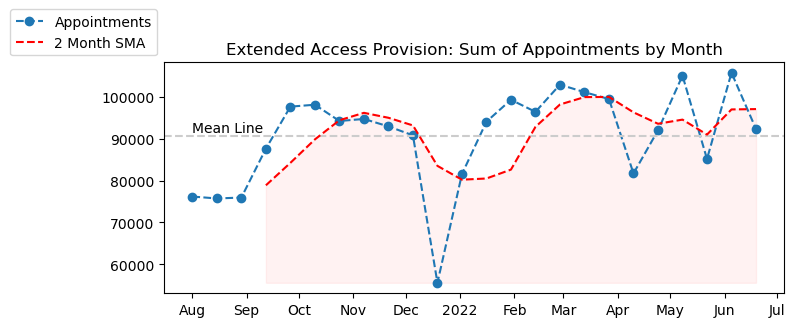

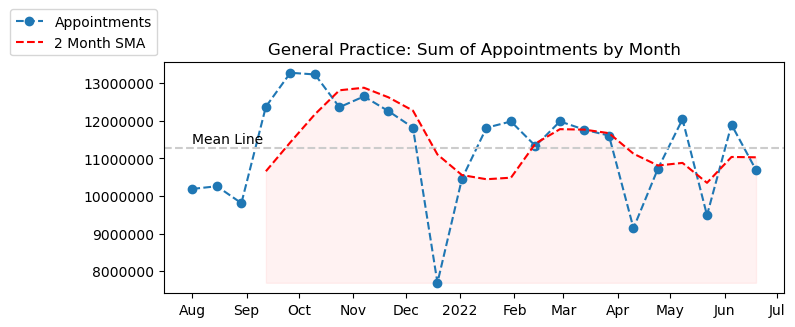

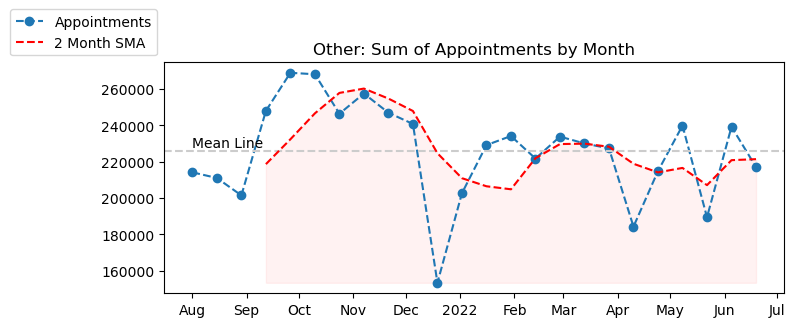

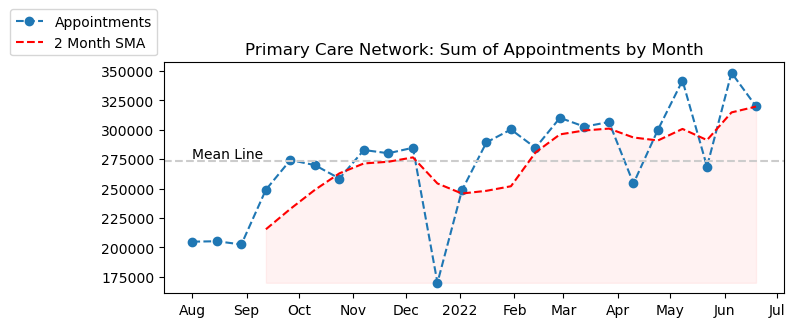

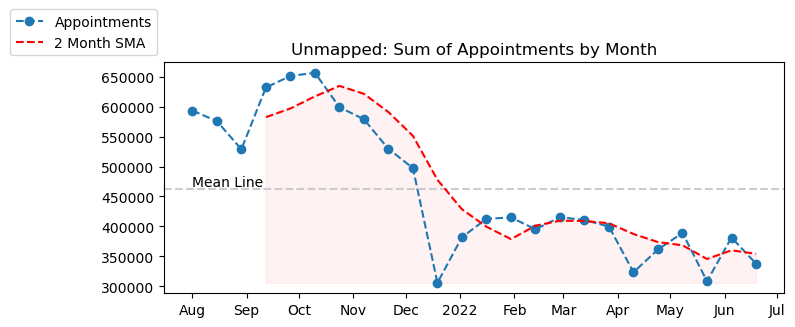

In [33]:
linechart_by_nc(nc_pivot_ss)

In [34]:
# create service settings pivot table from nc dataframe, index = appointment date bi-weekly
nc_pivot_ct = pd.pivot_table(nc, values='count_of_appointments',
                             index=[pd.Grouper(key='appointment_date', freq='14D')],
                             columns=['context_type'], aggfunc=np.sum) \
                             .reset_index()

nc_pivot_ct.head()

context_type,appointment_date,Care Related Encounter,Inconsistent Mapping,Unmapped
0,2021-08-01,9563146,1118661,593304
1,2021-08-15,9634488,1115394,575753
2,2021-08-29,9198915,1088460,528760
3,2021-09-12,11654905,1303746,631938
4,2021-09-26,12554379,1362121,651123


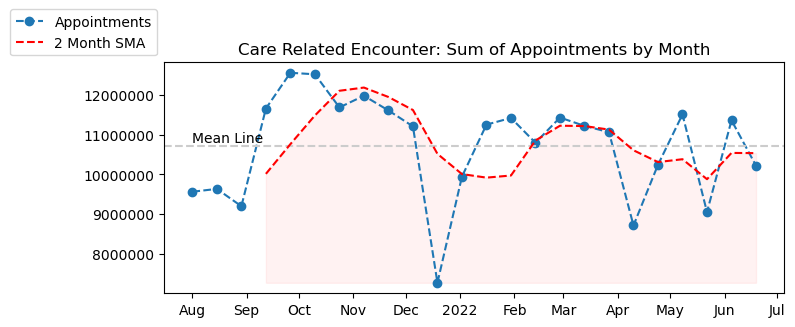

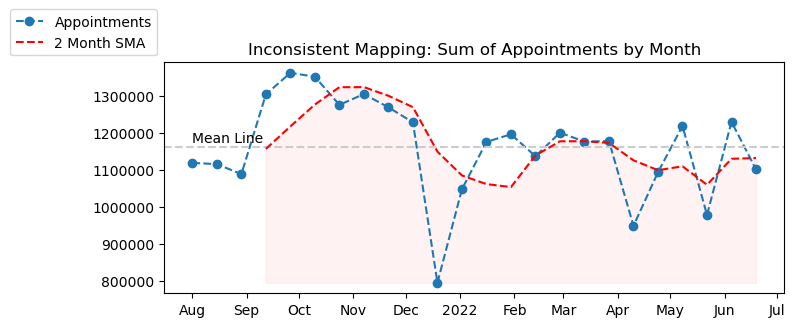

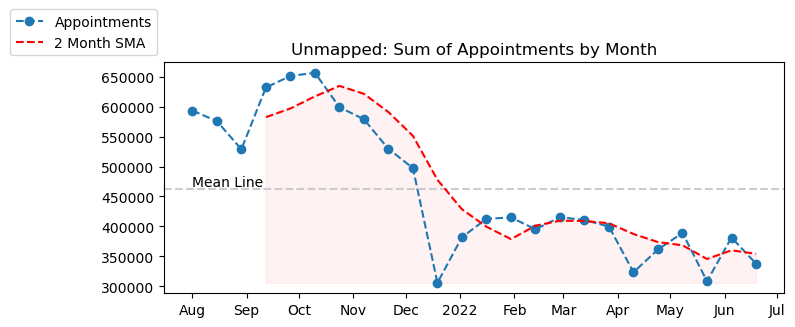

In [35]:
# call function to plot charts from nc_pivot_ct dataset
linechart_by_nc(nc_pivot_ct)

In [18]:
# Create groupby national category from the nc dataset and calculate percent of appointments
# NOTE: Remove categories with percentage_of_total below 1.5%
nc_groupby_nc = nc.groupby('national_category') \
                          ['count_of_appointments'].sum().reset_index()

nc_groupby_nc['percentage_of_total'] = ((nc_groupby_nc['count_of_appointments'] \
                                        /nc['count_of_appointments'].sum())*100).round(2)

nc_groupby_nc.sort_values(by='percentage_of_total', ascending=False, inplace=True)

nc_groupby_nc.head(20)

,national_category,count_of_appointments,percentage_of_total
4,General Consultation Routine,97271522,32.86
3,General Consultation Acute,53691150,18.14
2,Clinical Triage,41546964,14.03
11,Planned Clinics,28019748,9.46
7,Inconsistent Mapping,27890802,9.42
10,Planned Clinical Procedure,25702694,8.68
15,Unmapped,11080810,3.74
16,Unplanned Clinical Activity,3055794,1.03
6,Home Visit,2144452,0.72
14,Structured Medication Review,1858379,0.63


In [19]:
# Create groupby dataset for national categories by date (14 days)
nc_groupby_week_nc = nc.groupby([pd.Grouper(key='appointment_date', freq='14D'), \
                                'national_category']) \
                                ['count_of_appointments'] \
                                .sum() \
                                .reset_index()


nc_groupby_week_nc.head()

,appointment_date,national_category,count_of_appointments
0,2021-08-01,Care Home Needs Assessment & Personalised Care...,13970
1,2021-08-01,Care Home Visit,22034
2,2021-08-01,Clinical Triage,1743374
3,2021-08-01,General Consultation Acute,2005515
4,2021-08-01,General Consultation Routine,3665569


In [20]:
# remove national categories less than 1.5% of total appointments
for ind in nc_groupby_nc.index:
    if nc_groupby_nc['percentage_of_total'][ind] < 1.5:
        nc_groupby_week_nc = nc_groupby_week_nc[nc_groupby_week_nc['national_category'] \
                                                != nc_groupby_nc['national_category'][ind]]

In [21]:
# check to make sure I only have the national categories with more than 1.5% of total appointments
nc_groupby_week_nc.groupby('national_category')['count_of_appointments'].sum().reset_index()

,national_category,count_of_appointments
0,Clinical Triage,41546964
1,General Consultation Acute,53691150
2,General Consultation Routine,97271522
3,Inconsistent Mapping,27890802
4,Planned Clinical Procedure,25702694
5,Planned Clinics,28019748
6,Unmapped,11080810


In [24]:
# normalise dataframe nc_groupby_week_nc
nc_list = nc_groupby_nc["national_category"].tolist()

n = 1

for a in nc_list:
    if n != 1:
        df_1 = nc_groupby_week_nc.loc[nc_groupby_week_nc['national_category']==a].copy()
        df_1['scaled_appointments'] = max_abs_scaling(df_1['count_of_appointments'])
        df = pd.concat([df, df_1])
        n = n + 1
    else:
        df = nc_groupby_week_nc.loc[nc_groupby_week_nc['national_category']==a].copy()
        df['scaled_appointments'] = max_abs_scaling(df['count_of_appointments'])
        n = n + 1

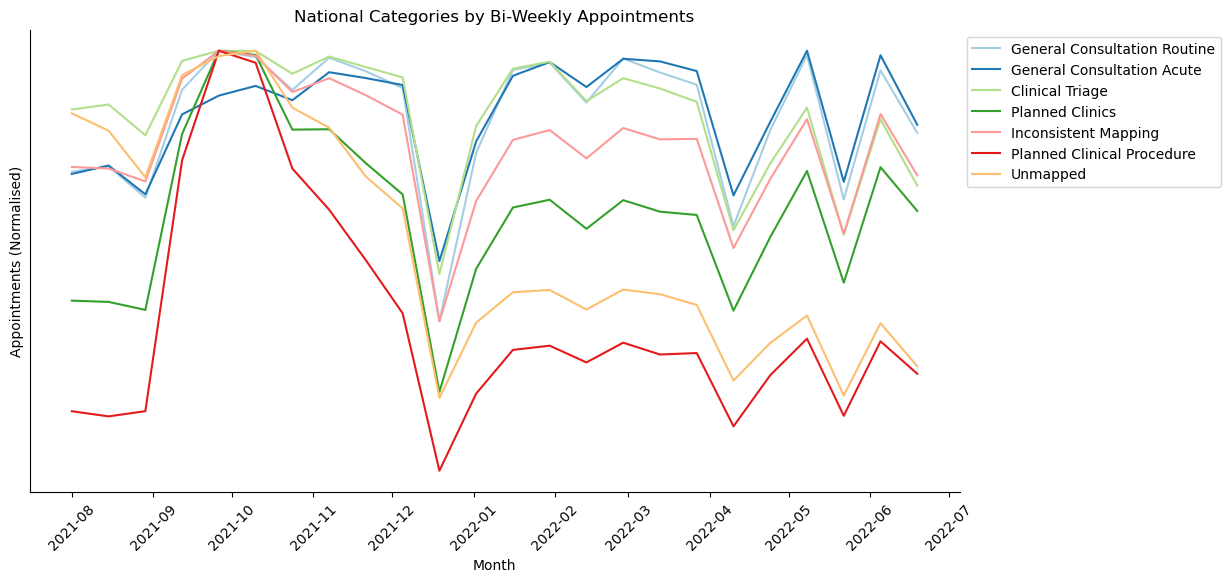

In [25]:
# plot dataframe nc_groupby_week_nc
fig, ax = plt.subplots(figsize=(12, 6))

# setup colour palette
sns.set_palette('Paired')

# plot the chart
sns.lineplot(x='appointment_date', y='scaled_appointments', hue='national_category', estimator=sum, data=df)

# place legend on right side outside
plt.legend(bbox_to_anchor=(1, 1), loc=2)

# setup labels, ticks, spines and title
plt.xticks(rotation=45)
ax.set(xlabel='Month', ylabel='Appointments (Normalised)')
ax.tick_params(left=False, bottom=True)
plt.yticks([]) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("National Categories by Bi-Weekly Appointments")
plt.grid(False)

# print chart
plt.show()

In [26]:
# show most common national category by sum of appointments
nc.groupby('national_category') \
          ['count_of_appointments'] \
           .sum().nlargest(7).reset_index()

,national_category,count_of_appointments
0,General Consultation Routine,97271522
1,General Consultation Acute,53691150
2,Clinical Triage,41546964
3,Planned Clinics,28019748
4,Inconsistent Mapping,27890802
5,Planned Clinical Procedure,25702694
6,Unmapped,11080810


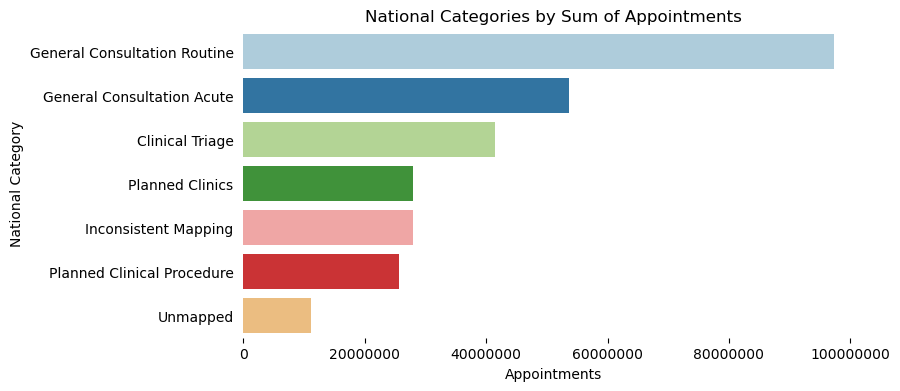

In [27]:
# plot bar chart to show 
fig, ax = plt.subplots(figsize=(8, 4))

# setup colour palette
sns.set_palette('Paired')

# plot chart
sns.barplot(x='count_of_appointments', y='national_category', \
            data=nc.groupby('national_category')['count_of_appointments'].sum().nlargest(7).reset_index(), \
            orient='h')

# setup labels, ticks, spines and title
ax.set(xlabel='Appointments', ylabel='National Category')
ax.ticklabel_format(style='plain', axis='x')
ax.tick_params(left=False, bottom=True)
sns.despine(left=True, bottom=True)
plt.title("National Categories by Sum of Appointments")

# print chart
plt.show()

# Objective 2
### Create four visualisations indicating the number of appointments for service setting per season. The seasons are summer (August 2021), autumn (October 2021), winter (January 2022), and spring (April 2022).

In [9]:
# create service_setting groupby dataset from nc
nc_groupby_ss = nc.groupby('service_setting')['count_of_appointments'] \
                           .sum().reset_index() \
                           .sort_values(by='count_of_appointments', ascending=False)

# calculate new column percentage of total appointments
nc_groupby_ss['percentage_of_total'] = ((nc_groupby_ss['count_of_appointments'] \
                                         /nc['count_of_appointments'].sum())*100).round(2)

nc_groupby_ss.head()

,service_setting,count_of_appointments,percentage_of_total
1,General Practice,270811691,91.48
4,Unmapped,11080810,3.74
3,Primary Care Network,6557386,2.21
2,Other,5420076,1.83
0,Extended Access Provision,2176807,0.74


In [10]:
# filter by GP only!!!
nc_gp_only = nc.loc[nc['service_setting']=='General Practice'].reset_index()

nc_gp_only.head()

,index,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,service_setting,context_type,national_category,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments
0,0,2021-08-01,E54000044,"NHS Buckinghamshire, Oxfordshire and Berkshire...",South East,General Practice,Care Related Encounter,Planned Clinical Procedure,Sunday,8,Summer,2021,56.37,12
1,2,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,General Practice,Care Related Encounter,Clinical Triage,Sunday,8,Summer,2021,56.87,2
2,3,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,General Practice,Care Related Encounter,General Consultation Acute,Sunday,8,Summer,2021,56.87,11
3,4,2021-08-01,E54000048,NHS Lancashire and South Cumbria Integrated Ca...,North West,General Practice,Care Related Encounter,General Consultation Routine,Sunday,8,Summer,2021,56.87,32
4,5,2021-08-01,E54000050,NHS North East and North Cumbria Integrated Ca...,North East and Yorkshire,General Practice,Care Related Encounter,General Consultation Acute,Sunday,8,Summer,2021,60.96,6


In [11]:
nc.groupby('appointment_date')['count_of_appointments'].sum().reset_index()

,appointment_date,count_of_appointments
0,2021-08-01,5627
1,2021-08-02,1222768
2,2021-08-03,1169920
3,2021-08-04,1093532
4,2021-08-05,1074043
...,...,...
329,2022-06-26,6574
330,2022-06-27,1410883
331,2022-06-28,1335598
332,2022-06-29,1237258


In [12]:
def linechart_one_month(df, months):
    
    for m, y in months.items():
        # prepare dataframe
        # search by month and year
        df_new = df[(df['appointment_month'] == m) & (df['appointment_year'] == y)]
        # set month as string variable
        month_str = df_new['appointment_date'].dt.month_name(locale='English').iloc[0]
        year_str = y
        third_day = dt.date(y, m, 3)
        # group new dataframe by date
        df_new = df_new.groupby('appointment_date')['count_of_appointments'].sum().reset_index()
        # set index as date
        df_new = df_new.set_index(['appointment_date'])
        # keep only appointments column
        df_new = df_new[['count_of_appointments']]
        
        # Create plot and set plot size
        ax = df_new.plot(figsize=(8, 4), marker="o",  linestyle="--")
        plt.ylim([0, 1600000])
        plt.axhline(y=1200000, color='r', linestyle='--')
        plt.text(y=1210000, x=third_day, s='Daily Capacity', fontsize='x-small')
        
        # show full tick labels on y axis
        ax.ticklabel_format(style='plain', axis='y')
    
        # format the x-axis
        dtFmt = mdates.DateFormatter('%a')
        plt.gca().xaxis.set_major_formatter(dtFmt) 
        # show every tick on x axes
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.xticks(rotation=45, fontweight='light', fontsize='x-small')
        
        # plot title, labels, legend, grid
        plt.title(f"GP Appointments in {month_str} {year_str}")
        plt.xlabel("Appointment Day")
        plt.ylabel("Number of Appointments")
        plt.legend(['GP Appointments'], loc='upper right')
        plt.grid(False)
        
        # show plot
        plt.show(block=False)
        
    return 

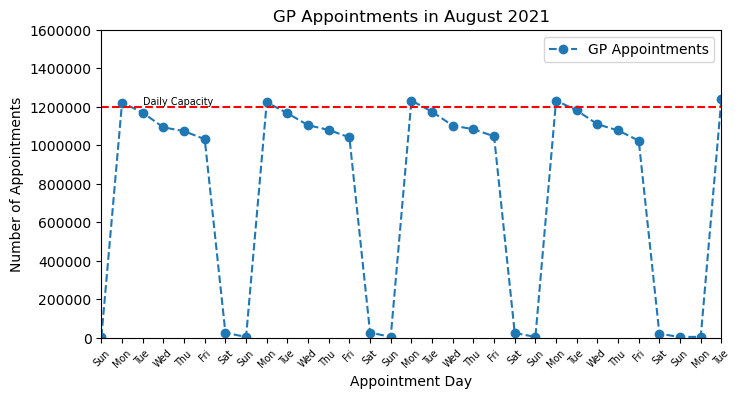

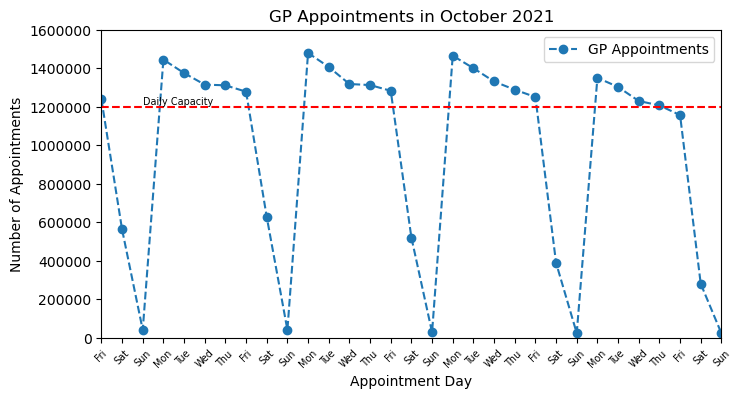

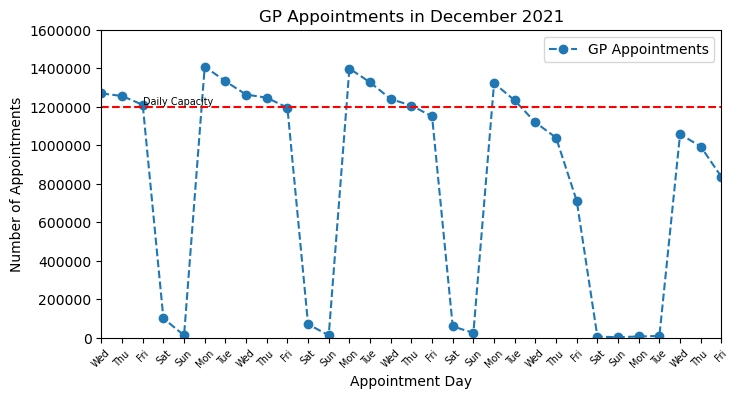

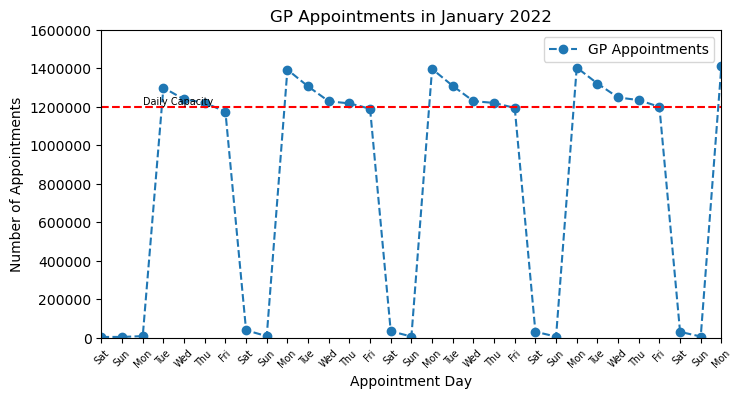

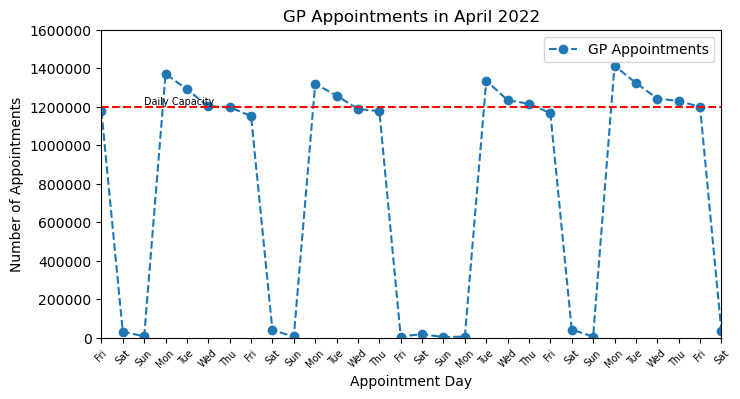

In [13]:
# Dictionary for selecting the month/year
months = {8 : 2021, 10 : 2021, 12 : 2021, 1 : 2022, 4 : 2022}

# Call function to print line charts from nc dataframe, months dictionary as filter
linechart_one_month(nc,months)

In [32]:
# groupby days of the week and service setting
nc_groupby_dayofweek = nc_gp_only.groupby(['appointment_dayofweek', 'service_setting'])['count_of_appointments'] \
                           .sum().reset_index() \
                           .sort_values(by='count_of_appointments', ascending=False)

# calculate new column percentage of total appoinments
nc_groupby_dayofweek['percentage_of_total'] = ((nc_groupby_dayofweek['count_of_appointments'] \
                                            /nc_gp_only['count_of_appointments'].sum())*100).round(4)

# show head
nc_groupby_dayofweek.head(7)

,appointment_dayofweek,service_setting,count_of_appointments,percentage_of_total
5,Tuesday,General Practice,56529751,20.8742
1,Monday,General Practice,54794619,20.2335
6,Wednesday,General Practice,53980690,19.9329
4,Thursday,General Practice,52084657,19.2328
0,Friday,General Practice,48099601,17.7613
2,Saturday,General Practice,4856121,1.7932
3,Sunday,General Practice,466252,0.1722


In [33]:
# Change dtype to ordered category
nc_groupby_dayofweek['appointment_dayofweek'] = nc_groupby_dayofweek['appointment_dayofweek']. \
       astype(pd.api.types.CategoricalDtype(categories=['Monday',
                                                        'Tuesday',
                                                        'Wednesday',
                                                        'Thursday',
                                                        'Friday',
                                                        'Saturday',
                                                        'Sunday'], ordered=True))

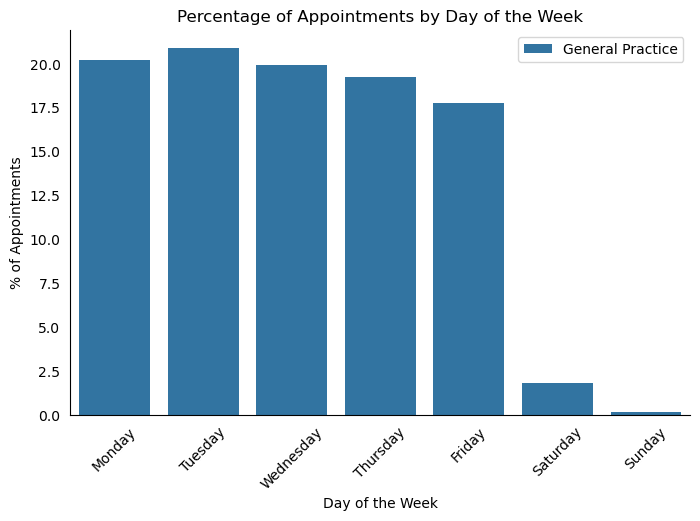

In [54]:
# Barplot of appointments by days of the week
fig, ax = plt.subplots(figsize=(8, 5))

# setup colour palette
sns.set_palette('tab10')

# setup chart
by_dayofweek = sns.barplot(x='appointment_dayofweek', y='percentage_of_total', \
                           hue='service_setting', data=nc_groupby_dayofweek, ax=ax)

# place legend on right side inside
plt.legend(bbox_to_anchor=(1, 1), loc=1)

# setup labels, ticks, spines and title
ax.set(xlabel='Day of the Week', ylabel='% of Appointments')
ax.tick_params(left=False, bottom=False)
sns.despine(right=True, top=True)
plt.title("Percentage of Appointments by Day of the Week")

for item in by_dayofweek.get_xticklabels():
    item.set_rotation(45)
    
# print chart
plt.show()

# Objective 3
### How did Covid effect monthly appointment data?

In [278]:
# Read the nc table from the database
ar_groupby_month = pd.read_sql('SELECT * from ar_groupby_month ORDER BY appointment_date', engine)

In [279]:
ar_groupby_month.head()

,appointment_date,sum,%,covid_status
0,2020-01-01,27199296,3.66,Pre-Covid
1,2020-02-01,24104621,3.25,Pre-Covid
2,2020-03-01,24053468,3.24,Pre-Covid
3,2020-04-01,16007881,2.16,Covid Lockdown
4,2020-05-01,16417212,2.21,Covid Lockdown


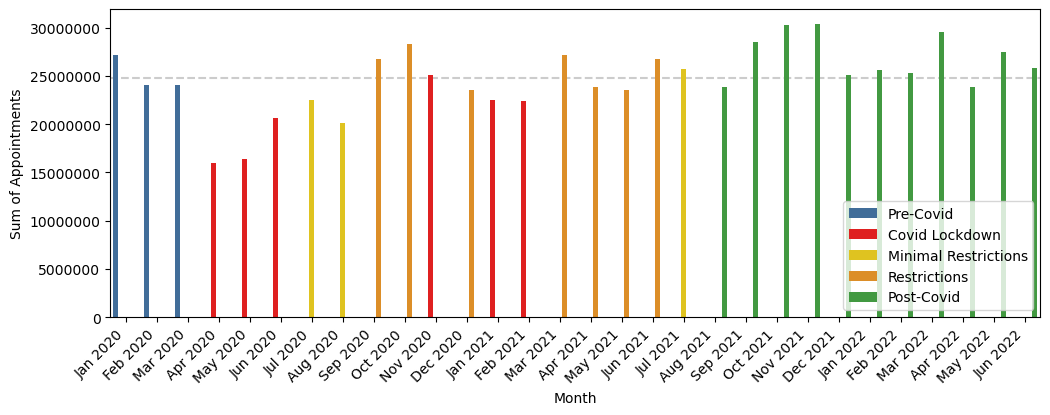

In [294]:
fig, ax = plt.subplots(figsize=(12, 4))

# the average monthly appointments
df_mean = ar_groupby_month['sum'].mean()

# use seaborn to plot the chart
sns.barplot(data=ar_groupby_month, x='appointment_date', y='sum', hue='covid_status', ax=ax, 
            palette={'Pre-Covid':'#326da8', 'Covid Lockdown':'r', 'Minimal Restrictions':'#ffd900','Restrictions':'#fa920a', 'Post-Covid':'#34a832'})

sns.set_palette('Paired')

# list of labels for x axis
x_dates = ar_groupby_month['appointment_date'].dt.strftime('%b %Y')
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# plot the mean line
ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--', zorder=0)

# label the axis
ax.set_ylabel(r'Sum of Appointments')
ax.set_xlabel(r'Month')

# show the legend
plt.legend(loc='lower right')

# show the graph
plt.show()

<Axes: xlabel='sum', ylabel='covid_status'>

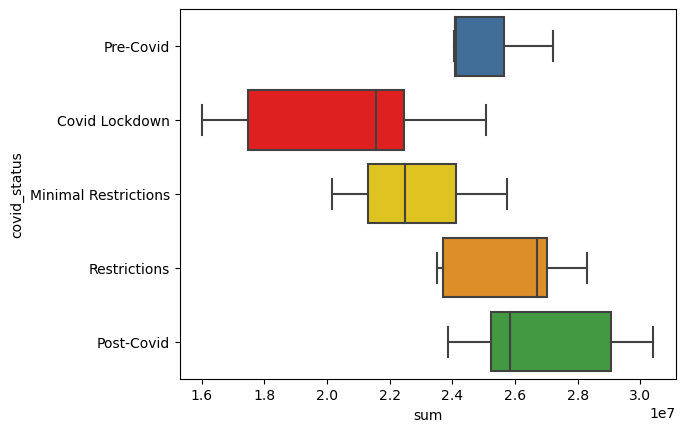

In [295]:
sns.boxplot(data=ar_groupby_month, x='sum', y='covid_status', palette={'Pre-Covid':'#326da8', 'Covid Lockdown':'r', 'Minimal Restrictions':'#ffd900','Restrictions':'#fa920a', 'Post-Covid':'#34a832'})

# Objective 4
### Create a map showing the percentage of unattended appointments by ICB

In [205]:
# set the filepath and load in a shapefile
fp = "D:\LSE\Assignment 2\icb_shape_files\ICB_APR_2023_EN_BSC.shp"
map_df = gpd.read_file(fp)

map_df['ICB23NM'] = map_df['ICB23NM'].str.replace('Integrated Care Board', '')

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,ICB23CD,ICB23NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E54000008,NHS Cheshire and Merseyside,374405,380936,-2.38572,53.3247,01aa947d-176c-4218-b9f5-6798c1191576,"POLYGON ((336404.203 422323.301, 335946.900 42..."
1,E54000010,NHS Staffordshire and Stoke-on-Trent,398243,334651,-2.02756,52.9093,3b28608f-bcd0-4cc3-b3fd-ee20085b1351,"POLYGON ((404258.156 368301.562, 406240.093 36..."
2,E54000011,"NHS Shropshire, Telford and Wrekin",350226,302960,-2.73668,52.6221,7771af61-6a62-4c2c-b9c9-1bfbdb20ba60,"POLYGON ((374820.812 344544.594, 374602.312 34..."
3,E54000013,NHS Lincolnshire,517984,358538,-0.23884,53.1110,00359689-8b11-467f-8e48-247c842cbef5,"POLYGON ((512490.999 414654.689, 512679.309 41..."
4,E54000015,"NHS Leicester, Leicestershire and Rutland",466552,310188,-1.01690,52.6853,221b43d6-c9ee-4fe9-bd15-c16166e272a7,"POLYGON ((482154.188 340911.500, 483722.808 34..."


<Axes: >

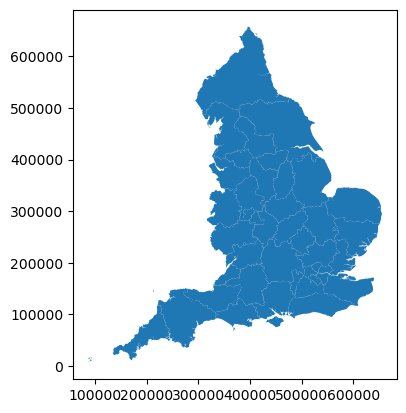

In [206]:
# plot the shape of the polygon
map_df.plot()

In [207]:
# Read the ar table from the database
icb = pd.read_sql('SELECT * from ar_pivot_icb_status', engine)

# drop the sum of appointments column
icb.drop(['sum_of_appointments'], axis=1, inplace=True)

In [208]:
# check the head
icb.head()

,icb_ons_name,percentage_of_dna
0,NHS Mid and South Essex,2.98
1,NHS Northamptonshire,3.09
2,"NHS Bath and North East Somerset, Swindon and ...",3.20
3,NHS Dorset,3.30
4,NHS Derby and Derbyshire,3.35


In [209]:
# merge geospatial data with the icb appointment data
merged = map_df.set_index('ICB23NM').join(icb.set_index('icb_ons_name')).reset_index()

merged.sort_values(by=['LONG'], inplace=True)
merged.head()

,ICB23NM,ICB23CD,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,percentage_of_dna
19,NHS Cornwall and the Isles of Scilly,E54000036,212497,64493,-4.64254,50.4502,77024d50-a54d-4c4b-9122-08c49c0c9bba,"MULTIPOLYGON (((88859.996 8832.496, 89270.734 ...",3.74
20,NHS Devon,E54000037,283157,93085,-3.65678,50.7256,05ceb46b-1675-4eb1-a8bb-c41a6db2e9f4,"MULTIPOLYGON (((264838.577 43779.215, 264643.3...",3.86
21,NHS Somerset,E54000038,309318,131066,-3.29569,51.0717,7d455181-8907-4096-bbe6-b1cbdab7d94e,"MULTIPOLYGON (((329170.090 148190.593, 329228....",4.60
2,"NHS Shropshire, Telford and Wrekin",E54000011,350226,302960,-2.73668,52.6221,7771af61-6a62-4c2c-b9c9-1bfbdb20ba60,"POLYGON ((374820.812 344544.594, 374602.312 34...",4.10
28,NHS Lancashire and South Cumbria,E54000048,352411,467532,-2.72924,54.1015,c3d322aa-b7c4-451d-95ab-c928ce0e2b2d,"MULTIPOLYGON (((341524.402 455205.098, 341196....",5.00


In [218]:
# The date range to show on the map
min_date = ar_subset_post_covid['appointment_date'].min().strftime('%m/%Y')
max_date = ar_subset_post_covid['appointment_date'].max().strftime('%m/%Y')

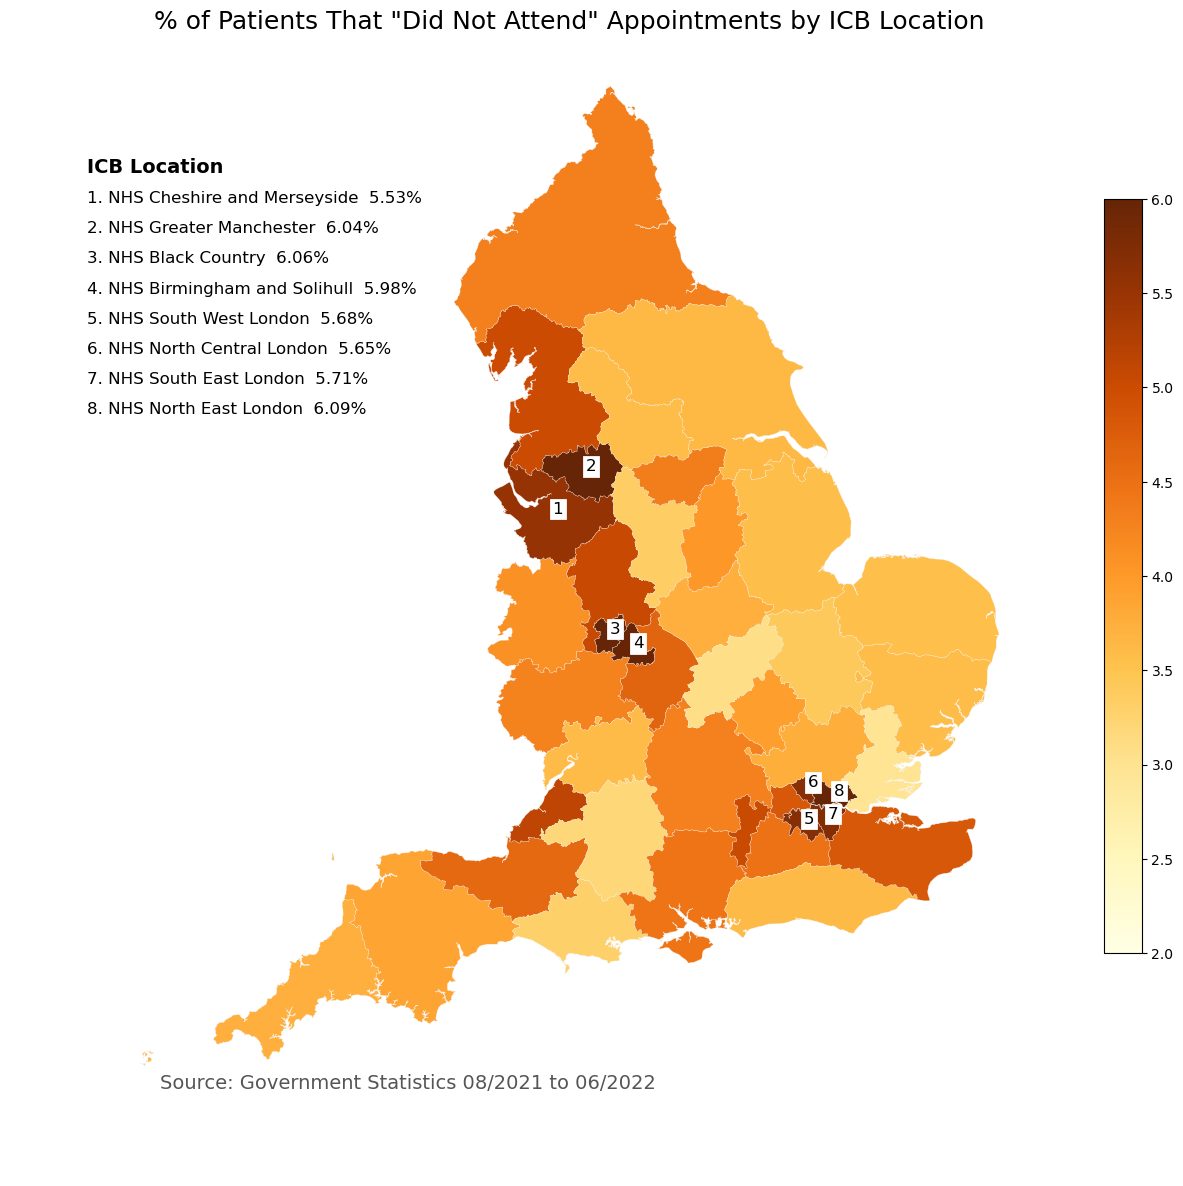

In [217]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage_of_dna'

# set the range for the choropleth
vmin, vmax = 2, 6

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 14))

# create map
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.2, ax=ax, edgecolor='whitesmoke', \
            vmin=vmin, vmax=vmax, legend=True, legend_kwds={'shrink': 0.7})

# remove the axis
ax.axis('off')

# add a title
ax.set_title('% of Patients That "Did Not Attend" Appointments by ICB Location', \
             fontdict={'fontsize': '18', 'fontweight' : '2'})

# create an annotation for the data source
ax.annotate(f"Source: Government Statistics {min_date} to {max_date}", xy=(0.1, .08), \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=14, color='#555555')

coord_y = 600000
coord_x = 50000

plt.text(coord_x, coord_y, "ICB Location", fontsize=14, horizontalalignment='left', color='black', weight='semibold')

n = 1
coord_y = coord_y - 20000
greater_than = 5.15
less_than = 0
   
merged.sort_values(by=['LONG'], inplace=True)

for x in merged.index:
    if merged['percentage_of_dna'][x] > greater_than or merged['percentage_of_dna'][x] < less_than:
        ax.annotate(text=f"{n}. {merged['ICB23NM'][x].replace('Integrated Care Board', '')} \
                    {'%.2f' % merged['percentage_of_dna'][x]}%", 
                    xy=merged.geometry[x].centroid.coords[0], 
                    ha='left', color='black', xytext=(coord_x, coord_y), fontsize=12)
        ax.annotate(text=n, 
                    xy=merged.geometry[x].centroid.coords[0], 
                    ha='left', color='black', 
                    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="white", lw=2), fontsize=12)
        coord_y = coord_y - 20000
        n = n + 1


# Objective 5
### Show how the time between booking and the actual appointment can impact whether or not patients will attend an appointment

In [245]:
# read the table from the database
ar_pivot_time_status = pd.read_sql('SELECT * from ar_pivot_time_status', engine)

In [246]:
# show the head
ar_pivot_time_status.head(10)

,time_between_book_and_appointment,sum_of_appointments,percentage_of_dna
0,Same Day,130976642,1.75
1,Unknown / Data Quality,190553,2.67
2,1 Day,25872974,4.04
3,2 to 7 Days,60734100,6.08
4,8 to 14 Days,37507051,7.65
5,15 to 21 Days,19454328,8.06
6,22 to 28 Days,11430584,8.18
7,More than 28 Days,9880538,9.21


In [247]:
# drop row unknown quality
ar_pivot_time_status.drop(1, axis=0, inplace=True)

In [248]:
# show the head
ar_pivot_time_status.head(10)

,time_between_book_and_appointment,sum_of_appointments,percentage_of_dna
0,Same Day,130976642,1.75
2,1 Day,25872974,4.04
3,2 to 7 Days,60734100,6.08
4,8 to 14 Days,37507051,7.65
5,15 to 21 Days,19454328,8.06
6,22 to 28 Days,11430584,8.18
7,More than 28 Days,9880538,9.21


<function matplotlib.pyplot.show(close=None, block=None)>

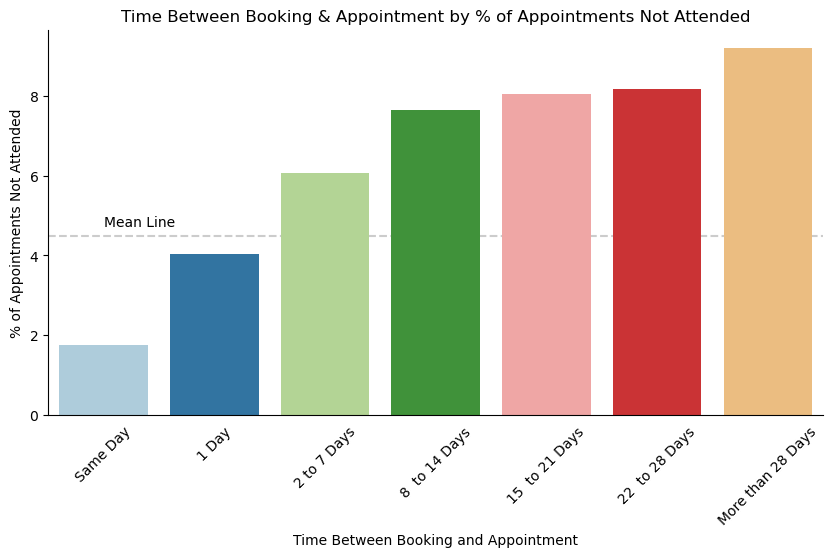

In [275]:
# Barplot of time between book and appointment by percentage of dna
fig, ax = plt.subplots(figsize=(10, 5))

# setup colour palette
sns.set_palette('Paired')

# the average appointments not attended
df_mean = 4.5

# use seaborn to plot the chart
by_time = sns.barplot(x='time_between_book_and_appointment', y='percentage_of_dna', \
                      data=ar_pivot_time_status, ax=ax)

# list of labels for x axis
for item in by_time.get_xticklabels():
    item.set_rotation(45)

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# plot the mean line
ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--', zorder=0)

# label the axis
ax.text(0, df_mean+(df_mean*0.05),'Mean Line')
ax.set_xlabel(r'Time Between Booking and Appointment')
ax.set_ylabel(r'% of Appointments Not Attended')
plt.title("Time Between Booking & Appointment by % of Appointments Not Attended")

ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

# place legend on right side inside
# plt.legend(bbox_to_anchor=(1, 1), loc=0)

plt.show



# Objective 7
### Plot how unattended appointments changed over time

In [296]:
# Read the ar table from the database
ar_groupby_month = pd.read_sql('SELECT * from ar_groupby_month', engine)

In [297]:
ar_groupby_month.head()

,appointment_date,sum,%,covid_status
0,2020-01-01,27199296,3.66,Pre-Covid
1,2020-02-01,24104621,3.25,Pre-Covid
2,2020-03-01,24053468,3.24,Pre-Covid
3,2020-04-01,16007881,2.16,Covid Lockdown
4,2020-05-01,16417212,2.21,Covid Lockdown


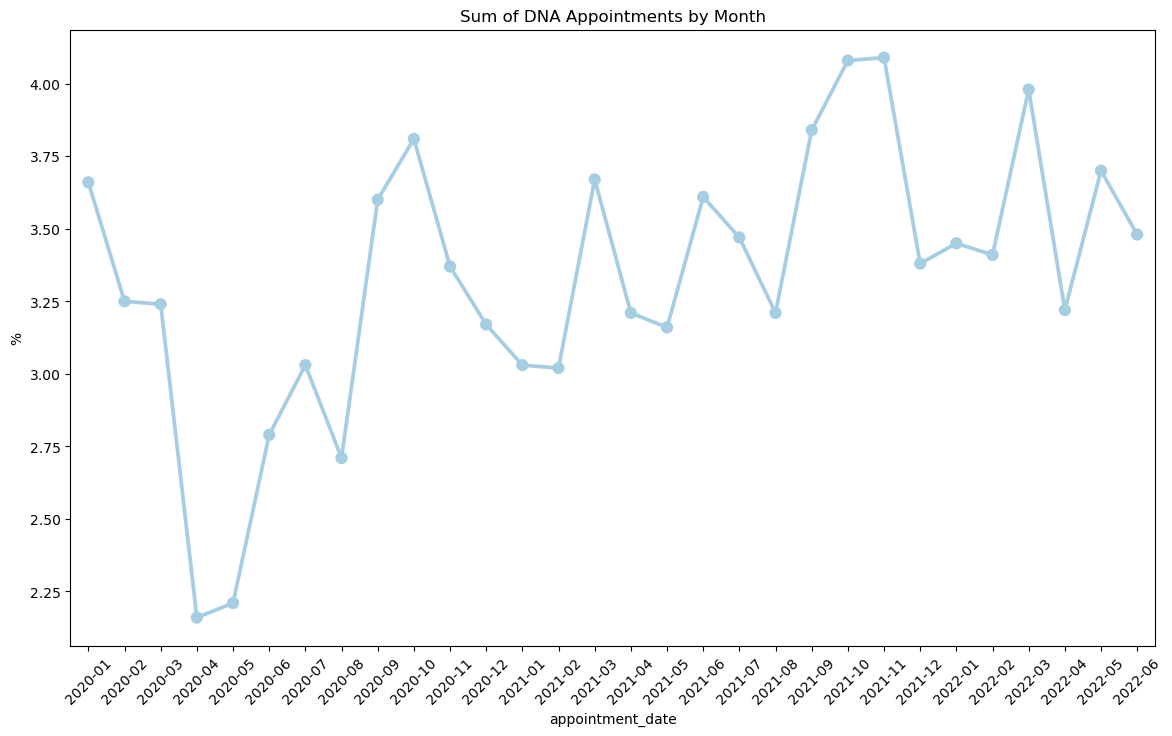

In [302]:
# Format dates.
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

sns.pointplot(x='appointment_date', y='%', data=ar_groupby_month).\
    set_title("Sum of % of DNA Appointments by Month")

x_labels = ar_groupby_month['appointment_date'].dt.strftime('%Y-%m')

ax.set_xticklabels(x_labels, rotation=45)

plt.show()

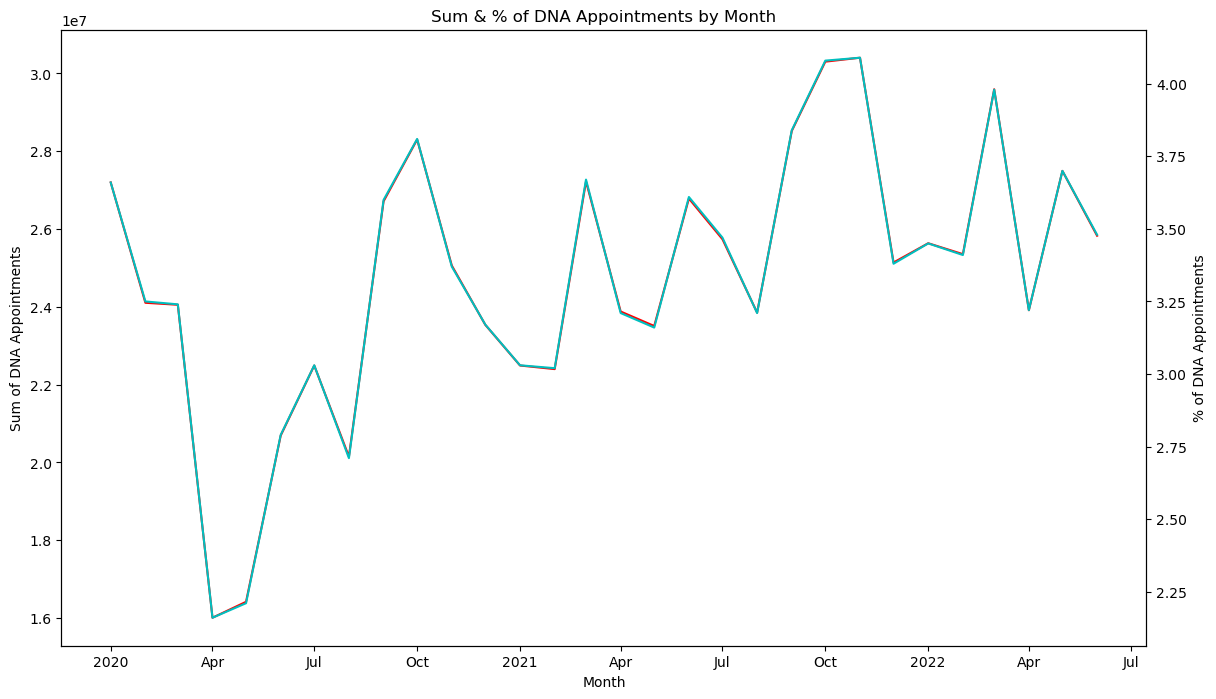

In [300]:
# Plotting different variables.
fig, dna_ax = plt.subplots()
fig.set_size_inches(14, 8)

per_dna_ax = dna_ax.twinx()

# Add labels.
dna_ax.set_title("Sum & % of DNA Appointments by Month")
dna_ax.set_xlabel("Month")
dna_ax.set_ylabel("Sum of DNA Appointments")

per_dna_ax.set_ylabel("% of DNA Appointments")

# Change date and time.
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
per_dna_ax.xaxis.set_major_formatter(formatter)
dna_ax.xaxis.set_major_formatter(formatter)

dna_ax = dna_ax.plot(ar_groupby_month.appointment_date, ar_groupby_month['sum'], 'r')
per_dna_ax = per_dna_ax.plot(ar_groupby_month.appointment_date, ar_groupby_month['%'], 'c')

# Objective 8
### Is there a relationship between sum of the appointments and patients not attending?

In [305]:
# Read the ar table from the database
ar_subset_post_covid = pd.read_sql('SELECT * from ar_subset_post_covid', engine)

In [306]:
ar_subset_post_covid.head()

,index,appointment_date,icb_ons_code,icb_ons_name,region_ons_name,appointment_status,hcp_type,appointment_mode,time_between_book_and_appointment,appointment_dayofweek,appointment_month,appointment_season,appointment_year,gp_per_100000,count_of_appointments,covid_restrictions
0,373403,2021-08-01,E54000022,NHS Norfolk and Waveney,East of England,Attended,GP,Home Visit,2 to 7 Days,Sunday,8,Summer,2021,58.45,67,None
1,373404,2021-08-01,E54000022,NHS Norfolk and Waveney,East of England,Attended,GP,Face-to-Face,1 Day,Sunday,8,Summer,2021,58.45,10131,None
2,373405,2021-08-01,E54000022,NHS Norfolk and Waveney,East of England,Attended,GP,Face-to-Face,15 to 21 Days,Sunday,8,Summer,2021,58.45,6140,None
3,373406,2021-08-01,E54000022,NHS Norfolk and Waveney,East of England,Attended,GP,Face-to-Face,2 to 7 Days,Sunday,8,Summer,2021,58.45,22310,None
4,373407,2021-08-01,E54000022,NHS Norfolk and Waveney,East of England,Attended,GP,Face-to-Face,22 to 28 Days,Sunday,8,Summer,2021,58.45,3089,None


In [345]:
table_1 = pd.pivot_table(ar_subset_post_covid, values =['count_of_appointments', 'gp_per_100000'],
    index =['appointment_date','region_ons_name'],
    columns =['appointment_status'], aggfunc={'count_of_appointments':np.sum, 'gp_per_100000':np.mean})

#aggfunc= {'Fee': 'mean', 'Discount': 'sum'})

table_1['sum_of_appointments'] = table_1['count_of_appointments']['Attended'] + table_1['count_of_appointments']['DNA'] + table_1['count_of_appointments']['Unknown']
table_1['percentage_of_DNA'] = (table_1['count_of_appointments']['DNA']/table_1['sum_of_appointments'])*100
table_1['gps_per_100000'] = table_1['gp_per_100000']['DNA']
                 
table_1.drop(['count_of_appointments', 'gp_per_100000'], axis=1, inplace=True)
    
table_1 = table_1.reset_index()

table_1.head()

# table_1 = table_1.rename_axis('Index')

# table_1.index.rename('Index', inplace=True)

,appointment_date,region_ons_name,sum_of_appointments,percentage_of_DNA,gps_per_100000
appointment_status,,,,,
0,2021-08-01,East of England,2723599,2.970628,52.556896
1,2021-08-01,London,3541514,5.121962,50.639513
2,2021-08-01,Midlands,4637457,3.988134,59.512433
3,2021-08-01,North East and Yorkshire,3852537,3.483627,59.243473
4,2021-08-01,North West,2862341,5.042900,61.894922


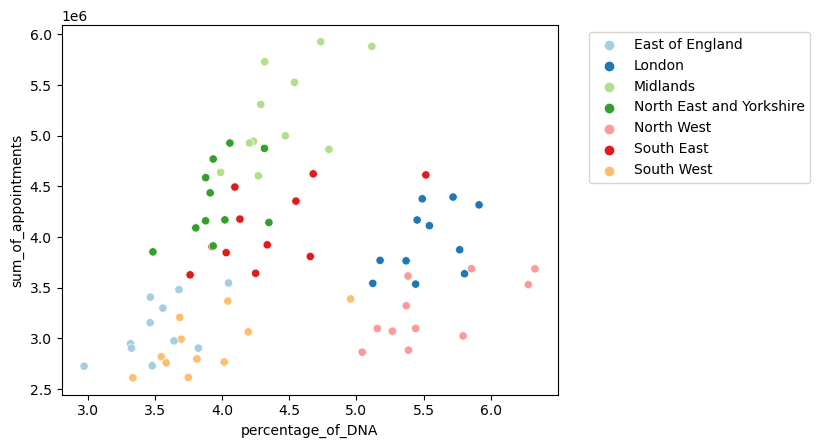

In [346]:
# Create the scatterplot.
sns.scatterplot(x='percentage_of_DNA',
               y='sum_of_appointments', hue='region_ons_name',
               data=table_1)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

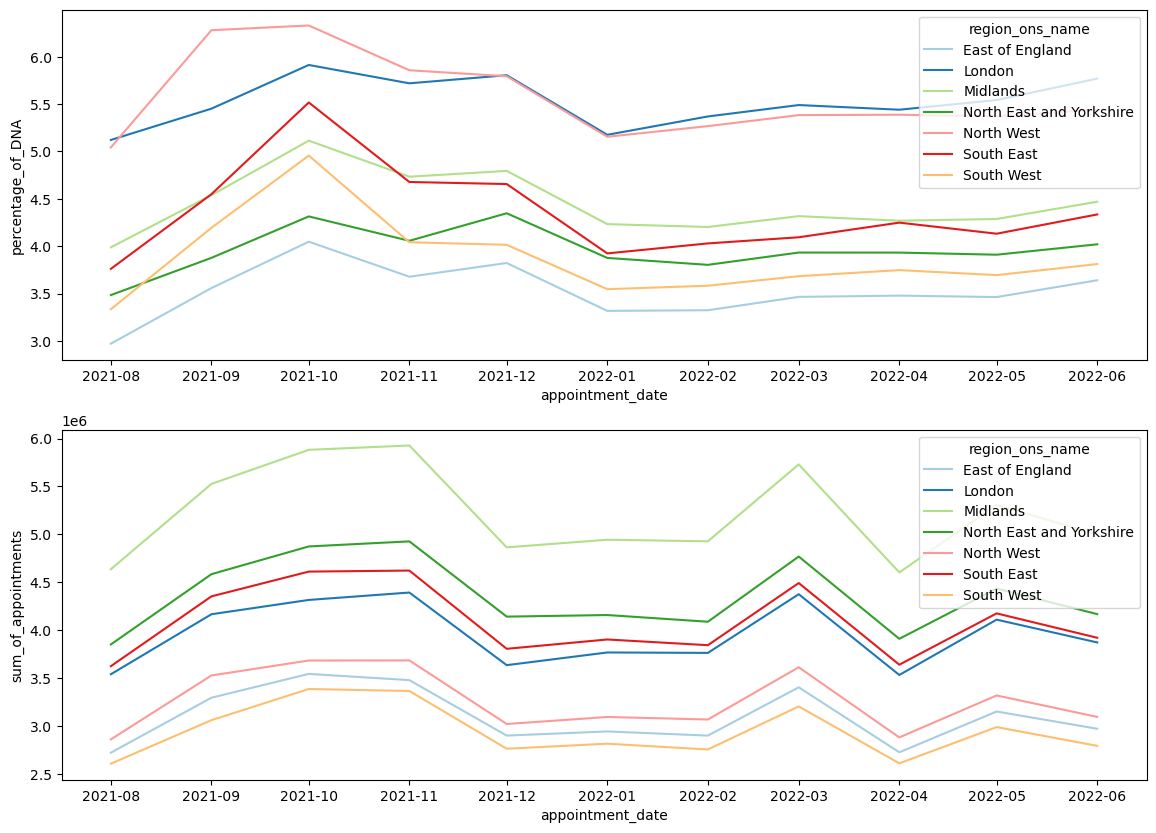

In [354]:
# Alternative methods.
fig, ax = plt.subplots(2)
fig.set_size_inches(14, 10)

# Create lineplots.
sns.lineplot(x='appointment_date',
             y='percentage_of_DNA',
             ax=ax[0],
             hue='region_ons_name',
             data=table_1)


sns.lineplot(x='appointment_date',
             y='sum_of_appointments',
             ax=ax[1],
             hue='region_ons_name',
             data=table_1)

# View the lineplots.
plt.show()

In [347]:
table_9 = ar.groupby('icb_ons_name')['gp_per_100000'].mean().reset_index()

table_9.sort_values(by=['gp_per_100000'], inplace=True)

table_9.reset_index(drop=True, inplace=True)

table_9

,icb_ons_name,gp_per_100000
0,NHS Kent and Medway,44.87
1,NHS North West London,46.74
2,"NHS Bedfordshire, Luton and Milton Keynes",47.01
3,NHS Mid and South Essex,48.20
4,NHS North East London,48.50
5,NHS South East London,50.03
6,NHS Sussex,50.54
7,NHS Frimley,51.82
8,NHS Suffolk and North East Essex,53.06
9,NHS North Central London,53.17


In [348]:
table_9.describe()

,gp_per_100000
count,42.000000
mean,56.922857
std,5.458675
min,44.870000
25%,53.690000
50%,57.930000
75%,60.047500
max,67.620000


<Axes: xlabel='gp_per_100000', ylabel='Count'>

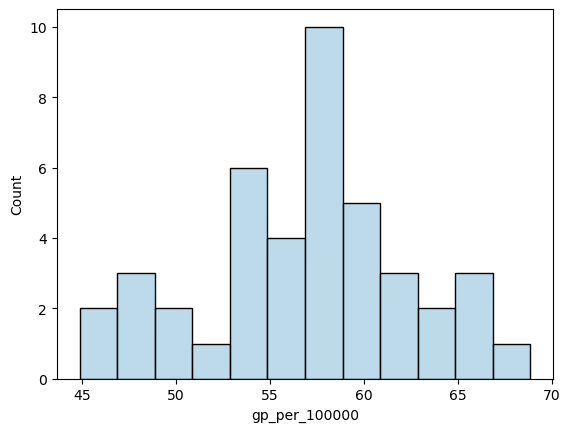

In [349]:
sns.histplot(data=table_9, x='gp_per_100000', binwidth=2)

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">9. Analyse The Twitter Data</h2></th>
        <th><a id='9'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

In [6]:
# Read the nc table from the database
tweets = pd.read_sql('SELECT * from tweets', engine)

In [7]:
# show the shape of the dataset
tweets.shape

(1174, 10)

In [8]:
# describe the the dataset
tweets.describe()

,tweet_id,tweet_retweet_count,tweet_favorite_count
count,1.174000e+03,1174.000000,1174.00000
mean,1.567612e+18,8.629472,0.37138
std,2.427553e+13,29.784675,2.04470
min,1.567574e+18,0.000000,0.00000
25%,1.567590e+18,0.000000,0.00000
50%,1.567611e+18,1.000000,0.00000
75%,1.567633e+18,3.000000,0.00000
max,1.567655e+18,303.000000,42.00000


In [9]:
# show the info of the dataset
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [13]:
# show the head of the dataset
tweets.head()

,tweet_id,tweet_full_text,tweet_entities,tweet_entities_hashtags,tweet_metadata,tweet_retweet_count,tweet_favorite_count,tweet_favorited,tweet_retweeted,tweet_lang
0,1567629223795527681,As Arkansas’ first Comprehensive Stroke Certif...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",0,0,False,False,en
1,1567582846612553728,RT @AndreaGrammer: Work-life balance is at the...,"{'hashtags': [{'text': 'PremiseHealth', 'indic...","#PremiseHealth, #hiring","{'iso_language_code': 'en', 'result_type': 're...",2,0,False,False,en
2,1567582787070304256,RT @OntarioGreens: $10 billion can go a long w...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",39,0,False,False,en
3,1567582767625428992,RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...,"{'hashtags': [{'text': 'NEW', 'indices': [20, ...",#NEW,"{'iso_language_code': 'en', 'result_type': 're...",5,0,False,False,en
4,1567582720460570625,ICYMI: Our recent blogs on Cybersecurity in Ac...,"{'hashtags': [{'text': 'blogs', 'indices': [18...","#blogs, #digitaltransformation, #cybersecurity...","{'iso_language_code': 'en', 'result_type': 're...",0,0,False,False,en


In [14]:
# show the count of column tweet_retweet_count
tweets['tweet_retweet_count'].value_counts()

tweet_retweet_count
0      526
1      215
2      114
3       70
5       35
4       27
7       18
12      16
8       15
73      14
9       13
6       12
208     12
35      10
37       6
11       6
10       5
53       5
44       4
150      4
63       4
76       3
85       3
41       3
62       3
207      3
68       3
78       2
23       2
24       2
72       2
16       2
13       1
49       1
48       1
15       1
107      1
14       1
79       1
20       1
39       1
19       1
303      1
57       1
40       1
54       1
169      1
Name: count, dtype: int64

In [15]:
# show the count of column tweet_favorite_count
tweets['tweet_favorite_count'].value_counts()

tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
17       1
12       1
10       1
8        1
13       1
11       1
7        1
20       1
28       1
14       1
18       1
9        1
42       1
Name: count, dtype: int64

In [17]:
# create new dataframe with only the object (string) datatypes
tweets_text = tweets[['tweet_full_text', 'tweet_entities', 'tweet_entities_hashtags', 'tweet_metadata', 'tweet_lang']]

tweets_text.head()

,tweet_full_text,tweet_entities,tweet_entities_hashtags,tweet_metadata,tweet_lang
0,As Arkansas’ first Comprehensive Stroke Certif...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",en
1,RT @AndreaGrammer: Work-life balance is at the...,"{'hashtags': [{'text': 'PremiseHealth', 'indic...","#PremiseHealth, #hiring","{'iso_language_code': 'en', 'result_type': 're...",en
2,RT @OntarioGreens: $10 billion can go a long w...,"{'hashtags': [{'text': 'Healthcare', 'indices'...",#Healthcare,"{'iso_language_code': 'en', 'result_type': 're...",en
3,RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...,"{'hashtags': [{'text': 'NEW', 'indices': [20, ...",#NEW,"{'iso_language_code': 'en', 'result_type': 're...",en
4,ICYMI: Our recent blogs on Cybersecurity in Ac...,"{'hashtags': [{'text': 'blogs', 'indices': [18...","#blogs, #digitaltransformation, #cybersecurity...","{'iso_language_code': 'en', 'result_type': 're...",en


In [18]:
# split the hashtags from the tweet_full_text column and store in the tags variable
tags = []

for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())
            
tags

['#healthcare',
 '#premisehealth',
 '#hiring',
 '#healthcare',
 '🚨#new:🚨',
 'look!\n\n#blogs',
 '#digitaltransformation',
 '#cybersecurity',
 '#accounting',
 '#finance',
 '#healthcare',
 'https://t.co/jrgqeqdme4\n.\n#firstcoastcna',
 '#cnaexam',
 '#cnaexampreparation',
 '#jacksonville',
 '#cnatraining',
 '#nurse',
 '#nursing',
 '#nurselife',
 '#nursepractitioner',
 '#nurseproblems',
 '#nursingschool',
 '#healthcare',
 '🚨#new:🚨',
 '#disparities.',
 '@karahartnett\n#healthcare',
 '#alert',
 '#insurance',
 '#data\nhttps://t.co/h9hlamr7p9',
 '#healthcare',
 '#healthcare',
 '❤️\n\n#healthcare',
 '#healthcare',
 '#hcldr',
 '#premisehealth',
 '#hiring',
 '#premisehealth',
 '#hiring',
 '#healthcare',
 '#qualitypatientcare',
 '#jobs',
 '#job',
 '#ascp2022',
 '#ascp100.',
 '#healthcare',
 '#healthsecretary',
 '#healthcare',
 '#ai,',
 '#sdoh,',
 '#healthcare',
 '\nhttps://t.co/ewe7jntj1e\n#tropicana',
 '#real',
 '#juice',
 '#healthcare',
 '#watch',
 '#worms',
 '#fruits',
 '#healthtips',
 '#tips',

In [20]:
# turn the tags variable into a pandas series
series_tags = pd.Series(tags)

# show the head of the pandas series
series_tags.head()

0       #healthcare
1    #premisehealth
2           #hiring
3       #healthcare
4           🚨#new:🚨
dtype: object

In [23]:
# create new dataframe named data to store the pandas series
# aggregate the tags using value_counts to get the count of each hashtag in the dataset
data = series_tags.value_counts().reset_index()

# show the head
data.head(30)

,index,count
0,#healthcare,716
1,#health,80
2,#medicine,41
3,#ai,40
4,#job,38
5,#medical,35
6,#strategy,30
7,#pharmaceutical,28
8,#digitalhealth,25
9,#marketing,25


In [24]:
# rename the index column to be word, this column stores the hashtags
data.rename(columns = {'index':'word'}, inplace = True)

In [25]:
# show the info of the new dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    1754 non-null   object
 1   count   1754 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.5+ KB


In [26]:
# describe the new dataframe
data.describe()

,count
count,1754.000000
mean,2.470353
std,17.462844
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,716.000000


In [28]:
# subset the dataframe to be count greater than 25
data_subset = data.loc[data['count'] > 25]

In [29]:
# show the shape
data_subset.shape

(8, 2)

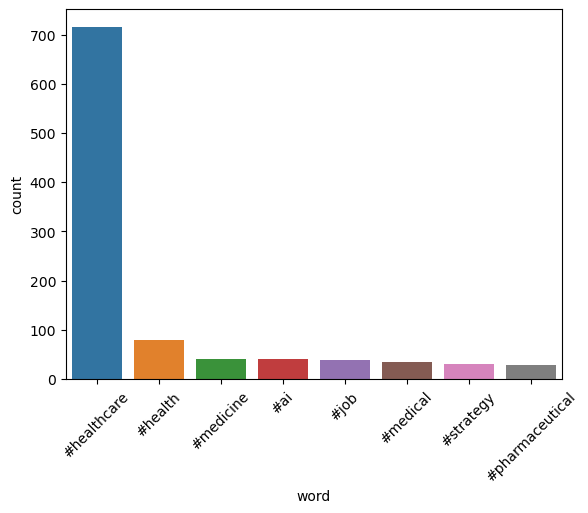

In [30]:
# plot the subset using barplot
sns.barplot(x='word', y='count', data=data_subset)
plt.xticks(rotation=45)
 
# Show the plot
plt.show()

- #healthcare was by far the top hashtag reported in this dataset, used more than 700 times.
- #health, #medicine, #medical, #pharmaceutical hashtags show up in the top 8.

> As a measure of public sentiment, analysis of real-time or historical social media data can provide valuable insights into the users/patients of the NHS.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">10. Recommendations</h2></th>
        <th><a id='10'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>